## Assignment 4. Exploring Change Detection in the Context of Filter Trading
1. Please go to the following https://finance.yahoo.com/. Find three different stocks of interest to you and download their data for the past 10 years of daily data (or for all years available for any companies who have had an Initial Public Offering in less than the last 10 years). You SHOULD submit this data with your assignment (That is a must). 
2. You should replicate the base code from Unit 8 for each of these stocks. 
3. You should then peform the analysis for three different possible buy/sell thresholds. Note, we used 10k, 20k, and 30k for the notes, but you can examine others. (NOTE: For someone extremely interested in exploring, that person could loop over a large number of thresholds to find that one which provided the greatest profitability based on historical data). 
4. Please provide a 500-700 word explanation of your findings. This would include discussion of a comparison of relative profitability of different thresholds

## Reading In Files

In [2]:
#step 1: Collect the data
import numpy as np
import pandas as pd

#Step 1 Read in the Data and Set the Date
TSLAdf = pd.read_csv("TSLA.csv")
METAdf = pd.read_csv("META.csv")
MSFTdf = pd.read_csv("MSFT.csv")

# Convert the date column to a datetime setting.
TSLAdf['Date'] = pd.to_datetime(TSLAdf['Date'])
METAdf['Date'] = pd.to_datetime(METAdf['Date'])
MSFTdf['Date'] = pd.to_datetime(MSFTdf['Date'])

# Set the index as a date.
TSLAdf.set_index('Date', inplace=True)
METAdf.set_index('Date', inplace=True)
MSFTdf.set_index('Date', inplace=True)


# Review basic info and observe head.
TSLAdf.info()
TSLAdf.head()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-04-15 to 2023-04-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2518 non-null   float64
 1   High       2518 non-null   float64
 2   Low        2518 non-null   float64
 3   Close      2518 non-null   float64
 4   Adj Close  2518 non-null   float64
 5   Volume     2518 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.7 KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-04-15,2.900000,2.920000,2.834000,2.886667,2.886667,25221000
2013-04-16,2.946000,3.076000,2.927333,3.039333,3.039333,47706000
2013-04-17,3.033333,3.063333,2.969333,3.030000,3.030000,31777500
2013-04-18,3.065333,3.173333,3.026000,3.131333,3.131333,50518500
2013-04-19,3.164000,3.325333,3.138000,3.188667,3.188667,45175500


In [3]:
TSLA_growth = TSLAdf.pct_change()
# Let us set the first date at 0 change. It's actually NaN.
TSLA_growth.loc['2013-04-15', 'Adj Close'] = 0
TSLA_growth

META_growth = METAdf.pct_change()
# Let us set the first date at 0 change. It's actually NaN.
META_growth.loc['2013-04-15', 'Adj Close'] = 0
META_growth

MSFT_growth = MSFTdf.pct_change()
# Let us set the first date at 0 change. It's actually NaN.
MSFT_growth.loc['2013-04-15', 'Adj Close'] = 0
MSFT_growth


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-04-15,NaN,NaN,NaN,NaN,0.000000,NaN
2013-04-16,0.008726,0.005521,0.006664,0.009759,0.009759,-0.062763
2013-04-17,-0.001730,-0.003432,-0.003484,-0.004833,-0.004832,0.000822
2013-04-18,0.003466,-0.002066,-0.003497,-0.001387,-0.001388,0.076946
2013-04-19,0.023143,0.043478,0.038947,0.034040,0.034039,0.753587
...,...,...,...,...,...,...
2023-04-06,-0.009236,0.017169,-0.003146,0.025533,0.025533,0.349221
2023-04-10,0.021186,-0.008491,0.009503,-0.007579,-0.007579,-0.223958
2023-04-11,-0.011964,-0.012500,-0.010783,-0.022668,-0.022668,0.180652


## TESLA H1

In [4]:
# Step 3 Calculate the mean growth rate and convert growth rate data to a list for manipulation.
# For the sake of this exercise, let k = the mean growth rate.
k = TSLA_growth['Adj Close'].mean()
# For the sake of this exercise, we will consider various thresholds for h. There are more sophisicated methods for setting h,
# but the article upon which this is based proposes simple thresholds, including 10k, 20k, 30k, et cetera.
h1 = 10*k
h2 = 20*k
h3 = 30*k
h4 = 60*k
# We will for ease of calculation, convert our dataframe column to a list.
Adj_Close = TSLA_growth['Adj Close'].tolist()


In [5]:
# Step 4 
# Initialize your cumulative sum
S = [0]
# Initialize your Instructions
I = ['Hold']
# Initialize assets invested
AINV = [10000]
# Initialize cash on hand.
CHELD = [0]
# Parameter on the share of cash on hand to use in case to buy if thresholds are reached.
bshare = 1
# Parameter on the share of assets to sell if thresholds are reached.
sshare = 0.15
# Set threshold
thresh = h1
# We will perform these calculations interatively.
for t in range(1, len(Adj_Close)):
    if len(S) == 1: #For the first run though, we simply calculate the value. This avoids an out of index problem.
        Snew = S[t-1] + (Adj_Close[t] - k) #This is the sum accumulator.
        S.append(Snew) # Populate the S list.
        I.append('Hold') # Populate Instruction List
        Avalue = AINV[t-1]*(1+Adj_Close[t]) #Increase the value of existing assets by the amount of the growth in the stock.
        AINV.append(Avalue) #Populate the assets invested file.
        CHchanged = CHELD[t-1]
        CHELD.append(CHchanged)
    else:
        if S[t-1] >= thresh: # Instructions if the upper threshold is passed. (Buy)
            Snew = 0 # Revert value back to zero
            S.append(Snew) 
            I.append('Buy')
            Avalue = AINV[t-1]*(1+Adj_Close[t]) + bshare*CHELD[t-1] #Increase the value of existing assets by the amount of the growth in the stock. Add any additional purchases.
            CHchanged = (1- bshare)*CHELD[t-1] #Adjust the cash on hand
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        elif S[t-1] <= -thresh: # Instructions if the lower threshold is passed. (Sell)
            Snew = 0
            S.append(Snew)
            I.append('Sell')
            Avalue = AINV[t-1]*(1+Adj_Close[t]) - sshare*AINV[t-1]
            CHchanged = CHELD[t-1] + sshare*AINV[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        else:
            Snew = S[t-1] + (Adj_Close[t] - k) # Instructions to hold are passed because the result is within boundaries.
            S.append(Snew)
            I.append('Hold')
            Avalue = AINV[t-1]*(1+Adj_Close[t])
            CHchanged = CHELD[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)

In [6]:
# Initialize assets invested
AINV2 = [10000]
for k in range(1, len(Adj_Close)):
       Avalue2 = AINV2[k-1]*(1+Adj_Close[k]) #Increase the value of existing assets by the amount of the growth in the stock.
       AINV2.append(Avalue2) #Populate the assets invested file.

In [7]:
# These steps are just adding columns to the data set.
TSLA_growth['S'] = S
TSLA_growth['Upper'] = h1
TSLA_growth['Lower'] = -h1
TSLA_growth['Instructions'] = I
TSLA_growth['Assets Invested'] = AINV
TSLA_growth['Cash on Hand'] = CHELD
TSLA_growth['Total Assets'] = TSLA_growth['Assets Invested'] + TSLA_growth['Cash on Hand']
TSLA_growth['Alt Assets'] = AINV2 
TSLA_growth

,Open,High,Low,Close,Adj Close,Volume,S,Upper,Lower,Instructions,Assets Invested,Cash on Hand,Total Assets,Alt Assets
Date,,,,,,,,,,,,,,
2013-04-15,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.023112,-0.023112,Hold,10000.000000,0.000000,10000.000000,10000.000000
2013-04-16,0.015862,0.053425,0.032933,0.052887,0.052887,0.891519,0.050575,0.023112,-0.023112,Hold,10528.865990,0.000000,10528.865990,10528.865990
2013-04-17,0.029645,-0.004118,0.014348,-0.003071,-0.003071,-0.333889,0.000000,0.023112,-0.023112,Buy,10496.534585,0.000000,10496.534585,10496.534585
2013-04-18,0.010549,0.035909,0.019084,0.033443,0.033443,0.589757,0.031132,0.023112,-0.023112,Hold,10847.572650,0.000000,10847.572650,10847.572650
2013-04-19,0.032188,0.047899,0.037013,0.018310,0.018310,-0.105763,0.000000,0.023112,-0.023112,Buy,11046.189256,0.000000,11046.189256,11046.189256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-06,-0.039051,-0.022498,-0.021876,-0.002480,-0.002480,-0.074876,0.000000,0.023112,-0.023112,Sell,392777.229902,69516.416315,462293.646217,641085.369390
2023-04-10,-0.017151,-0.006921,-0.020196,-0.002972,-0.002972,0.147723,-0.005283,0.023112,-0.023112,Hold,391609.886029,69516.416315,461126.302344,639180.047439
2023-04-11,0.037513,0.022096,0.054171,0.012357,0.012357,-0.185599,0.004763,0.023112,-0.023112,Hold,396449.026353,69516.416315,465965.442668,647078.422970


In [8]:
# Make a copy of the data frame.
TSLAdf_year = TSLA_growth.copy(deep = True)
# Reset the index on the copy to get the actual dates as a column.
TSLAdf_year.reset_index(inplace=True)
# Create a number column for just year
TSLAdf_year['year'] = pd.DatetimeIndex(TSLAdf_year['Date']).year
# Find the unique values in a column
years = TSLAdf_year.year.unique()
# Count total years from length of array
n_years = len(years) - 1
# Calculate the approximate annual growth rate of total assets
approx_growth = (TSLA_growth['Total Assets'][len(TSLA_growth['Total Assets']) - 1]/TSLA_growth['Total Assets'][0])**(1/n_years) - 1
approx_growth_alt = (TSLA_growth['Alt Assets'][len(TSLA_growth['Alt Assets']) - 1]/TSLA_growth['Alt Assets'][0])**(1/n_years) - 1
print("Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of {:.2%} is {:.2%}".format(thresh, approx_growth))
print("The annualized rate of growth using a hold strategy is {:.2%}".format(approx_growth_alt))

Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of 2.31% is 46.78%
The annualized rate of growth using a hold strategy is 51.67%


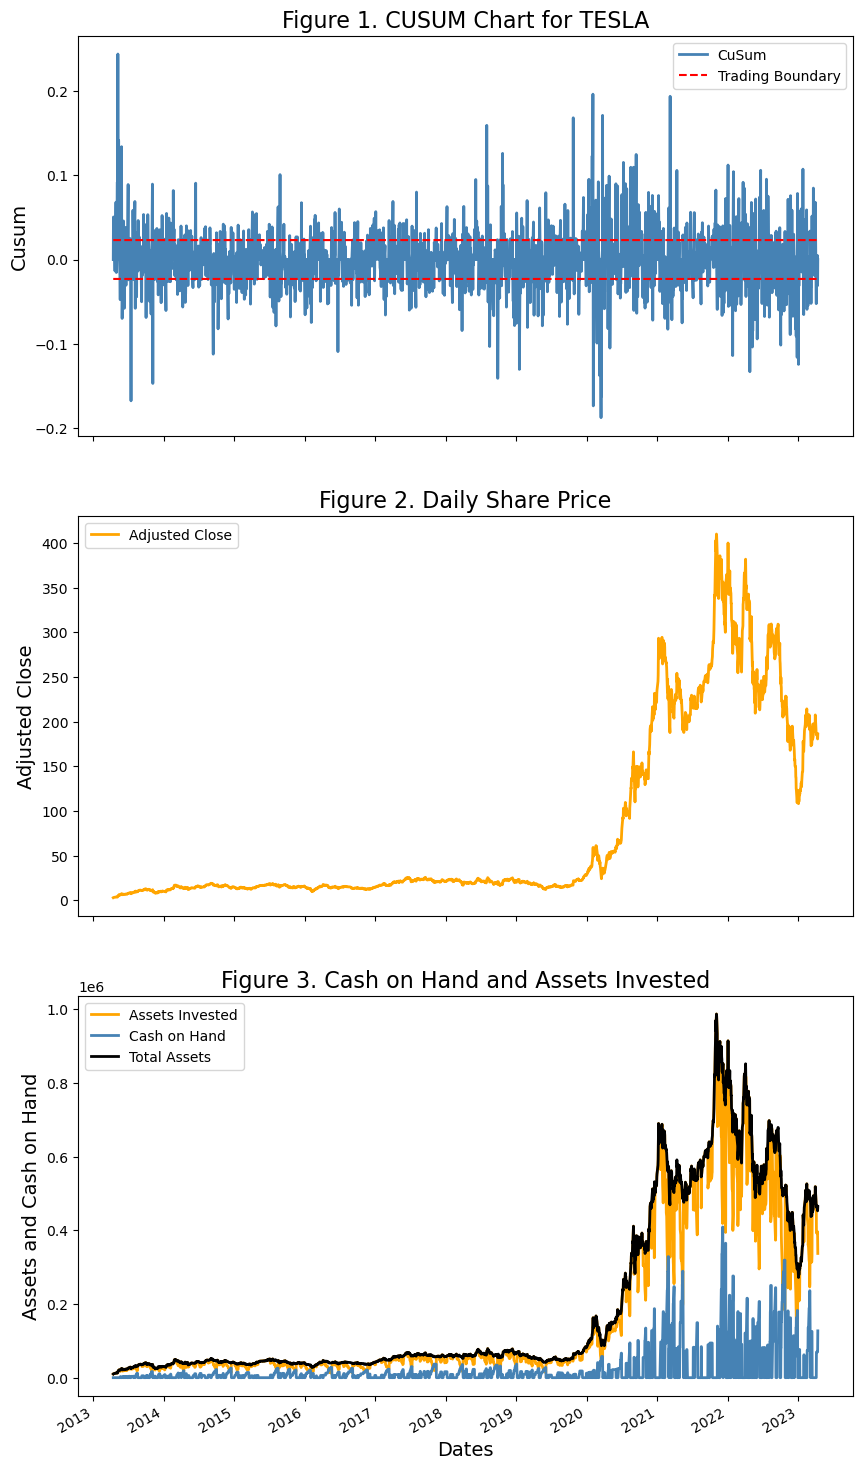

Hold    1783
Sell     387
Buy      348
Name: Instructions, dtype: int64

In [9]:
import matplotlib.pyplot as plt 
#Truncate data sets for graphs
TSLA_growth_t = TSLA_growth['2013-04-15':'2023-04-13']
TSLAdf_t = TSLAdf['2013-04-15':'2023-04-13']
#Configure subplots
fig, axs = plt.subplots(3, sharex = True, figsize=(10,20))
#Specifying cusum plot
axs[0].plot(TSLA_growth_t['S'], label='CuSum', color='steelblue', linewidth = 2)
axs[0].plot(TSLA_growth_t['Upper'], label='Trading Boundary', color='red', linestyle='dashed')
axs[0].plot(TSLA_growth_t['Lower'], color='red', linestyle='dashed')
#Specifying share price plot
axs[1].plot(TSLAdf_t['Adj Close'], label="Adjusted Close", color='orange', linewidth=2)
#Specifying share price plot
axs[2].plot(TSLA_growth_t['Assets Invested'], label="Assets Invested", color='orange', linewidth=2)
axs[2].plot(TSLA_growth_t['Cash on Hand'], label="Cash on Hand", color='steelblue', linewidth=2)
axs[2].plot(TSLA_growth_t['Total Assets'], label="Total Assets", color='black', linewidth=2)
#add legends for both figures.
axs[0].legend()
axs[1].legend()
axs[2].legend()

#add axis labels and titles
axs[0].set_ylabel('Cusum', fontsize=14)
axs[1].set_ylabel('Adjusted Close', fontsize=14)
axs[2].set_ylabel('Assets and Cash on Hand', fontsize=14)
plt.xlabel('Dates', fontsize=14)
axs[0].set_title('Figure 1. CUSUM Chart for TESLA', fontsize = 16)
axs[1].set_title('Figure 2. Daily Share Price', fontsize = 16)
axs[2].set_title('Figure 3. Cash on Hand and Assets Invested', fontsize = 16)
plt.gcf().autofmt_xdate()
#display plot
plt.show()
TSLA_growth['Instructions'].value_counts()

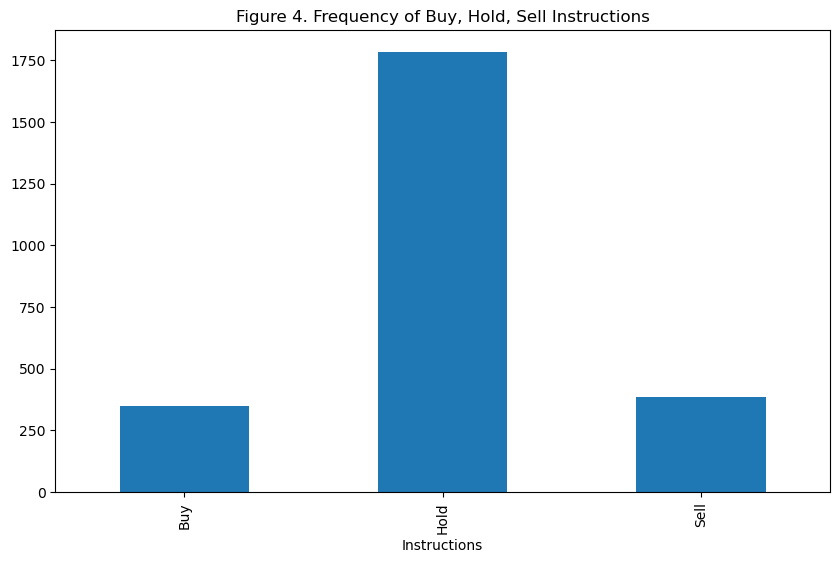

In [10]:
#Counting Frequencies of Buy, Hold, Sell Instructions
count = TSLA_growth_t.groupby(['Instructions']).count()
#Convert one column to a dataframe
countdf = pd.DataFrame(data=count['S'])
countdf.plot.bar(figsize = (10,6), title="Figure 4. Frequency of Buy, Hold, Sell Instructions", legend=False)
plt.show()

## TESLA H2

Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of 4.62% is 46.71%
The annualized rate of growth using a hold strategy is 51.67%


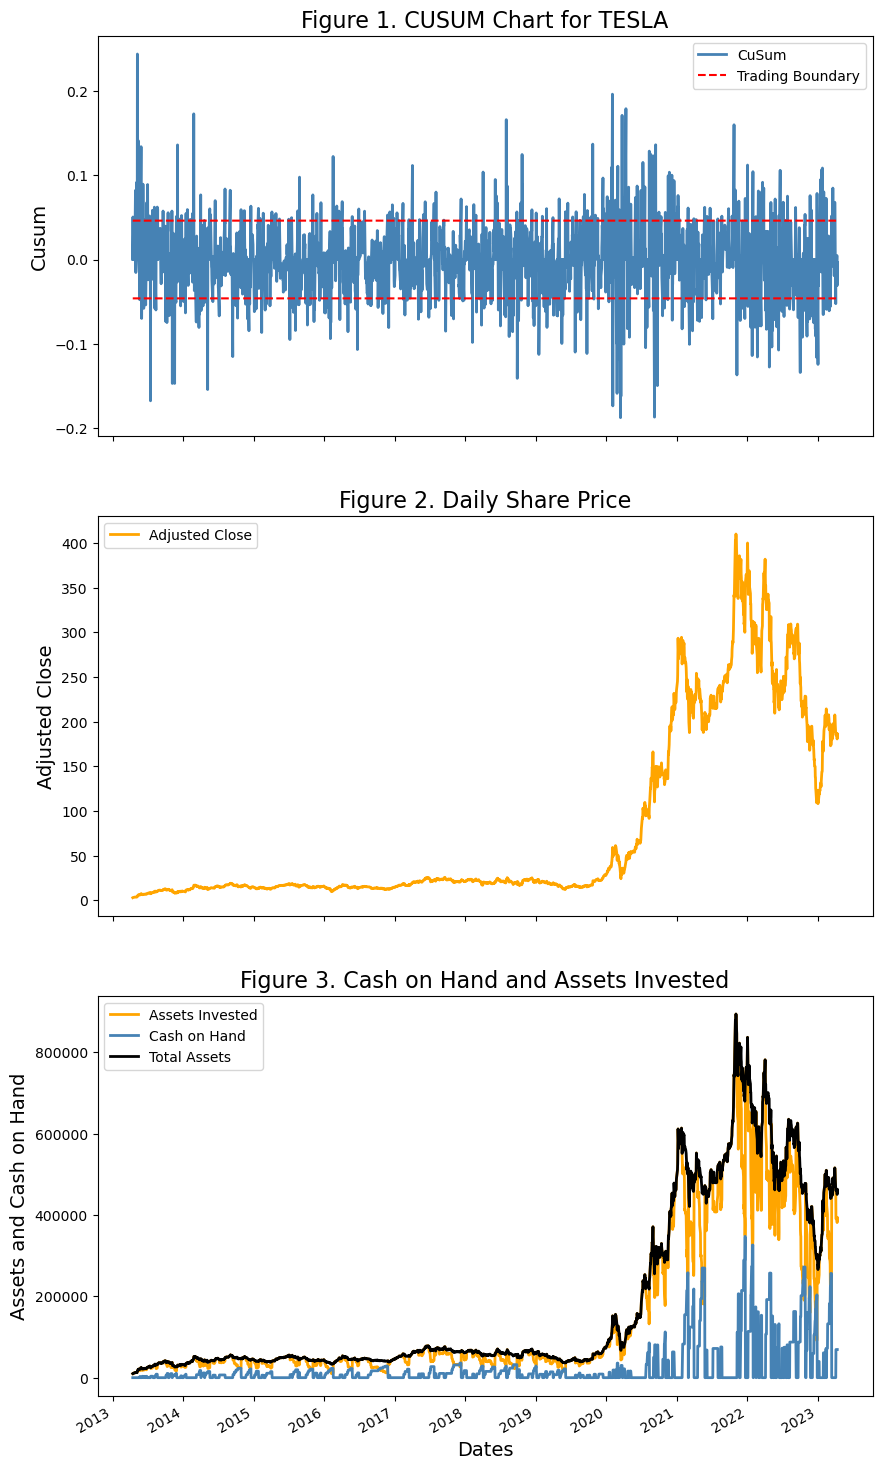

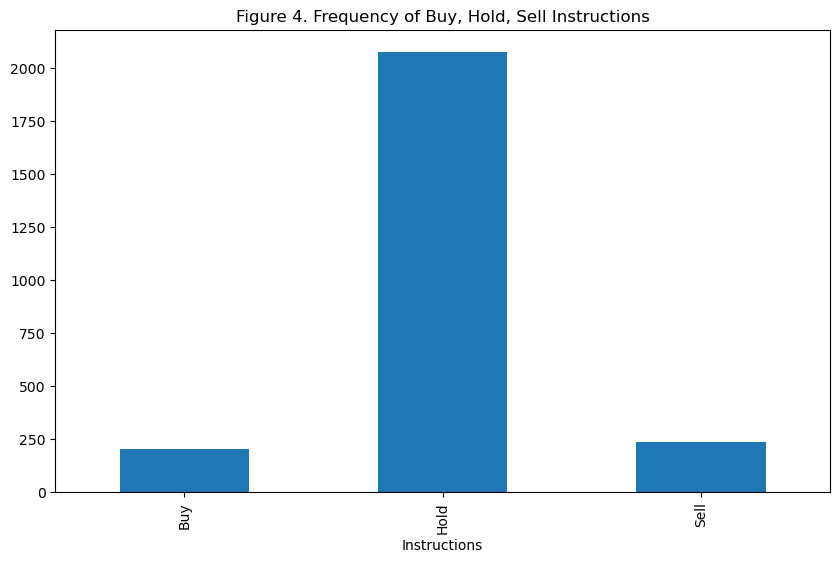

In [32]:
# Step 3 Calculate the mean growth rate and convert growth rate data to a list for manipulation.
# For the sake of this exercise, let k = the mean growth rate.
k = TSLA_growth['Adj Close'].mean()
# For the sake of this exercise, we will consider various thresholds for h. There are more sophisicated methods for setting h,
# but the article upon which this is based proposes simple thresholds, including 10k, 20k, 30k, et cetera.
h1 = 10*k
h2 = 20*k
h3 = 30*k
h4 = 60*k
# We will for ease of calculation, convert our dataframe column to a list.
Adj_Close = TSLA_growth['Adj Close'].tolist()


# Step 4 
# Initialize your cumulative sum
S = [0]
# Initialize your Instructions
I = ['Hold']
# Initialize assets invested
AINV = [10000]
# Initialize cash on hand.
CHELD = [0]
# Parameter on the share of cash on hand to use in case to buy if thresholds are reached.
bshare = 1
# Parameter on the share of assets to sell if thresholds are reached.
sshare = 0.15
# Set threshold
thresh = h2
# We will perform these calculations interatively.
for t in range(1, len(Adj_Close)):
    if len(S) == 1: #For the first run though, we simply calculate the value. This avoids an out of index problem.
        Snew = S[t-1] + (Adj_Close[t] - k) #This is the sum accumulator.
        S.append(Snew) # Populate the S list.
        I.append('Hold') # Populate Instruction List
        Avalue = AINV[t-1]*(1+Adj_Close[t]) #Increase the value of existing assets by the amount of the growth in the stock.
        AINV.append(Avalue) #Populate the assets invested file.
        CHchanged = CHELD[t-1]
        CHELD.append(CHchanged)
    else:
        if S[t-1] >= thresh: # Instructions if the upper threshold is passed. (Buy)
            Snew = 0 # Revert value back to zero
            S.append(Snew) 
            I.append('Buy')
            Avalue = AINV[t-1]*(1+Adj_Close[t]) + bshare*CHELD[t-1] #Increase the value of existing assets by the amount of the growth in the stock. Add any additional purchases.
            CHchanged = (1- bshare)*CHELD[t-1] #Adjust the cash on hand
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        elif S[t-1] <= -thresh: # Instructions if the lower threshold is passed. (Sell)
            Snew = 0
            S.append(Snew)
            I.append('Sell')
            Avalue = AINV[t-1]*(1+Adj_Close[t]) - sshare*AINV[t-1]
            CHchanged = CHELD[t-1] + sshare*AINV[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        else:
            Snew = S[t-1] + (Adj_Close[t] - k) # Instructions to hold are passed because the result is within boundaries.
            S.append(Snew)
            I.append('Hold')
            Avalue = AINV[t-1]*(1+Adj_Close[t])
            CHchanged = CHELD[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
            
# Initialize assets invested
AINV2 = [10000]
for k in range(1, len(Adj_Close)):
       Avalue2 = AINV2[k-1]*(1+Adj_Close[k]) #Increase the value of existing assets by the amount of the growth in the stock.
       AINV2.append(Avalue2) #Populate the assets invested file.
    
# These steps are just adding columns to the data set.
TSLA_growth['S'] = S
TSLA_growth['Upper'] = h2
TSLA_growth['Lower'] = -h2
TSLA_growth['Instructions'] = I
TSLA_growth['Assets Invested'] = AINV
TSLA_growth['Cash on Hand'] = CHELD
TSLA_growth['Total Assets'] = TSLA_growth['Assets Invested'] + TSLA_growth['Cash on Hand']
TSLA_growth['Alt Assets'] = AINV2 
TSLA_growth

# Make a copy of the data frame.
TSLAdf_year = TSLA_growth.copy(deep = True)
# Reset the index on the copy to get the actual dates as a column.
TSLAdf_year.reset_index(inplace=True)
# Create a number column for just year
TSLAdf_year['year'] = pd.DatetimeIndex(TSLAdf_year['Date']).year
# Find the unique values in a column
years = TSLAdf_year.year.unique()
# Count total years from length of array
n_years = len(years) - 1
# Calculate the approximate annual growth rate of total assets
approx_growth = (TSLA_growth['Total Assets'][len(TSLA_growth['Total Assets']) - 1]/TSLA_growth['Total Assets'][0])**(1/n_years) - 1
approx_growth_alt = (TSLA_growth['Alt Assets'][len(TSLA_growth['Alt Assets']) - 1]/TSLA_growth['Alt Assets'][0])**(1/n_years) - 1
print("Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of {:.2%} is {:.2%}".format(thresh, approx_growth))
print("The annualized rate of growth using a hold strategy is {:.2%}".format(approx_growth_alt))

import matplotlib.pyplot as plt 
#Truncate data sets for graphs
TSLA_growth_t = TSLA_growth['2013-04-15':'2023-04-13']
TSLAdf_t = TSLAdf['2013-04-15':'2023-04-13']
#Configure subplots
fig, axs = plt.subplots(3, sharex = True, figsize=(10,20))
#Specifying cusum plot
axs[0].plot(TSLA_growth_t['S'], label='CuSum', color='steelblue', linewidth = 2)
axs[0].plot(TSLA_growth_t['Upper'], label='Trading Boundary', color='red', linestyle='dashed')
axs[0].plot(TSLA_growth_t['Lower'], color='red', linestyle='dashed')
#Specifying share price plot
axs[1].plot(TSLAdf_t['Adj Close'], label="Adjusted Close", color='orange', linewidth=2)
#Specifying share price plot
axs[2].plot(TSLA_growth_t['Assets Invested'], label="Assets Invested", color='orange', linewidth=2)
axs[2].plot(TSLA_growth_t['Cash on Hand'], label="Cash on Hand", color='steelblue', linewidth=2)
axs[2].plot(TSLA_growth_t['Total Assets'], label="Total Assets", color='black', linewidth=2)
#add legends for both figures.
axs[0].legend()
axs[1].legend()
axs[2].legend()

#add axis labels and titles
axs[0].set_ylabel('Cusum', fontsize=14)
axs[1].set_ylabel('Adjusted Close', fontsize=14)
axs[2].set_ylabel('Assets and Cash on Hand', fontsize=14)
plt.xlabel('Dates', fontsize=14)
axs[0].set_title('Figure 1. CUSUM Chart for TESLA', fontsize = 16)
axs[1].set_title('Figure 2. Daily Share Price', fontsize = 16)
axs[2].set_title('Figure 3. Cash on Hand and Assets Invested', fontsize = 16)
plt.gcf().autofmt_xdate()
#display plot
plt.show()
TSLA_growth['Instructions'].value_counts()

#Counting Frequencies of Buy, Hold, Sell Instructions
count = TSLA_growth_t.groupby(['Instructions']).count()
#Convert one column to a dataframe
countdf = pd.DataFrame(data=count['S'])
countdf.plot.bar(figsize = (10,6), title="Figure 4. Frequency of Buy, Hold, Sell Instructions", legend=False)
plt.show()

## TESLA H3

Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of 6.93% is 48.37%
The annualized rate of growth using a hold strategy is 51.67%


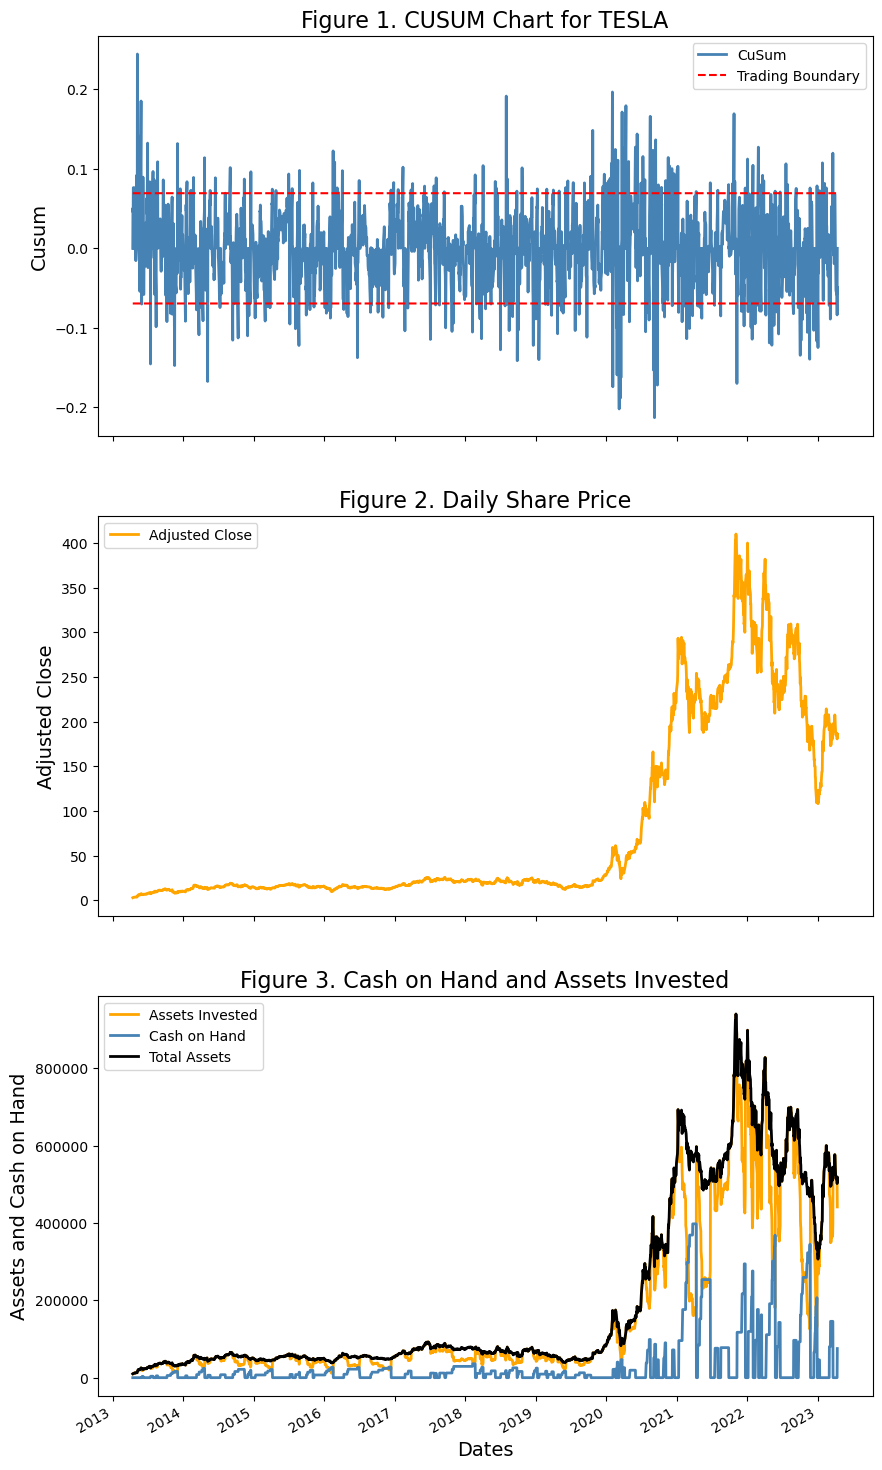

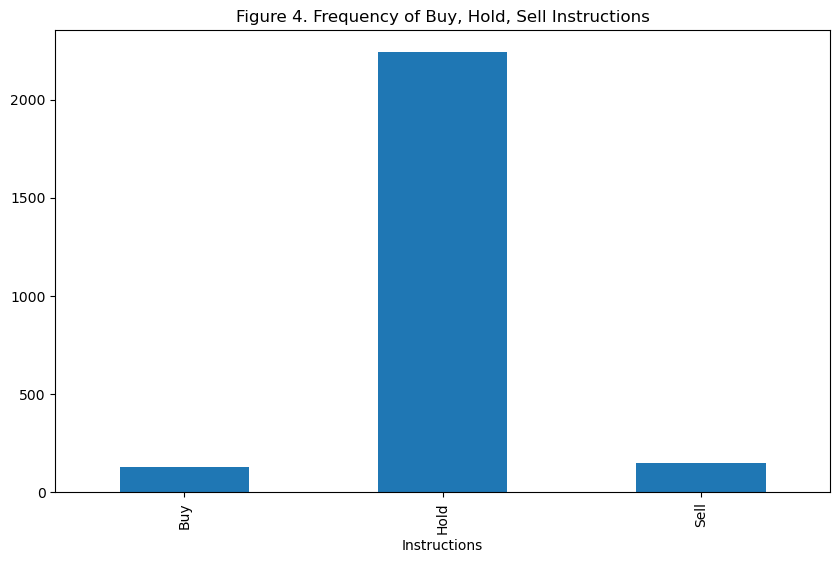

In [33]:
# Step 3 Calculate the mean growth rate and convert growth rate data to a list for manipulation.
# For the sake of this exercise, let k = the mean growth rate.
k = TSLA_growth['Adj Close'].mean()
# For the sake of this exercise, we will consider various thresholds for h. There are more sophisicated methods for setting h,
# but the article upon which this is based proposes simple thresholds, including 10k, 20k, 30k, et cetera.
h1 = 10*k
h2 = 20*k
h3 = 30*k
h4 = 60*k
# We will for ease of calculation, convert our dataframe column to a list.
Adj_Close = TSLA_growth['Adj Close'].tolist()


# Step 4 
# Initialize your cumulative sum
S = [0]
# Initialize your Instructions
I = ['Hold']
# Initialize assets invested
AINV = [10000]
# Initialize cash on hand.
CHELD = [0]
# Parameter on the share of cash on hand to use in case to buy if thresholds are reached.
bshare = 1
# Parameter on the share of assets to sell if thresholds are reached.
sshare = 0.15
# Set threshold
thresh = h3
# We will perform these calculations interatively.
for t in range(1, len(Adj_Close)):
    if len(S) == 1: #For the first run though, we simply calculate the value. This avoids an out of index problem.
        Snew = S[t-1] + (Adj_Close[t] - k) #This is the sum accumulator.
        S.append(Snew) # Populate the S list.
        I.append('Hold') # Populate Instruction List
        Avalue = AINV[t-1]*(1+Adj_Close[t]) #Increase the value of existing assets by the amount of the growth in the stock.
        AINV.append(Avalue) #Populate the assets invested file.
        CHchanged = CHELD[t-1]
        CHELD.append(CHchanged)
    else:
        if S[t-1] >= thresh: # Instructions if the upper threshold is passed. (Buy)
            Snew = 0 # Revert value back to zero
            S.append(Snew) 
            I.append('Buy')
            Avalue = AINV[t-1]*(1+Adj_Close[t]) + bshare*CHELD[t-1] #Increase the value of existing assets by the amount of the growth in the stock. Add any additional purchases.
            CHchanged = (1- bshare)*CHELD[t-1] #Adjust the cash on hand
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        elif S[t-1] <= -thresh: # Instructions if the lower threshold is passed. (Sell)
            Snew = 0
            S.append(Snew)
            I.append('Sell')
            Avalue = AINV[t-1]*(1+Adj_Close[t]) - sshare*AINV[t-1]
            CHchanged = CHELD[t-1] + sshare*AINV[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        else:
            Snew = S[t-1] + (Adj_Close[t] - k) # Instructions to hold are passed because the result is within boundaries.
            S.append(Snew)
            I.append('Hold')
            Avalue = AINV[t-1]*(1+Adj_Close[t])
            CHchanged = CHELD[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
            
# Initialize assets invested
AINV2 = [10000]
for k in range(1, len(Adj_Close)):
       Avalue2 = AINV2[k-1]*(1+Adj_Close[k]) #Increase the value of existing assets by the amount of the growth in the stock.
       AINV2.append(Avalue2) #Populate the assets invested file.
    
# These steps are just adding columns to the data set.
TSLA_growth['S'] = S
TSLA_growth['Upper'] = h3
TSLA_growth['Lower'] = -h3
TSLA_growth['Instructions'] = I
TSLA_growth['Assets Invested'] = AINV
TSLA_growth['Cash on Hand'] = CHELD
TSLA_growth['Total Assets'] = TSLA_growth['Assets Invested'] + TSLA_growth['Cash on Hand']
TSLA_growth['Alt Assets'] = AINV2 
TSLA_growth

# Make a copy of the data frame.
TSLAdf_year = TSLA_growth.copy(deep = True)
# Reset the index on the copy to get the actual dates as a column.
TSLAdf_year.reset_index(inplace=True)
# Create a number column for just year
TSLAdf_year['year'] = pd.DatetimeIndex(TSLAdf_year['Date']).year
# Find the unique values in a column
years = TSLAdf_year.year.unique()
# Count total years from length of array
n_years = len(years) - 1
# Calculate the approximate annual growth rate of total assets
approx_growth = (TSLA_growth['Total Assets'][len(TSLA_growth['Total Assets']) - 1]/TSLA_growth['Total Assets'][0])**(1/n_years) - 1
approx_growth_alt = (TSLA_growth['Alt Assets'][len(TSLA_growth['Alt Assets']) - 1]/TSLA_growth['Alt Assets'][0])**(1/n_years) - 1
print("Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of {:.2%} is {:.2%}".format(thresh, approx_growth))
print("The annualized rate of growth using a hold strategy is {:.2%}".format(approx_growth_alt))

import matplotlib.pyplot as plt 
#Truncate data sets for graphs
TSLA_growth_t = TSLA_growth['2013-04-15':'2023-04-13']
TSLAdf_t = TSLAdf['2013-04-15':'2023-04-13']
#Configure subplots
fig, axs = plt.subplots(3, sharex = True, figsize=(10,20))
#Specifying cusum plot
axs[0].plot(TSLA_growth_t['S'], label='CuSum', color='steelblue', linewidth = 2)
axs[0].plot(TSLA_growth_t['Upper'], label='Trading Boundary', color='red', linestyle='dashed')
axs[0].plot(TSLA_growth_t['Lower'], color='red', linestyle='dashed')
#Specifying share price plot
axs[1].plot(TSLAdf_t['Adj Close'], label="Adjusted Close", color='orange', linewidth=2)
#Specifying share price plot
axs[2].plot(TSLA_growth_t['Assets Invested'], label="Assets Invested", color='orange', linewidth=2)
axs[2].plot(TSLA_growth_t['Cash on Hand'], label="Cash on Hand", color='steelblue', linewidth=2)
axs[2].plot(TSLA_growth_t['Total Assets'], label="Total Assets", color='black', linewidth=2)
#add legends for both figures.
axs[0].legend()
axs[1].legend()
axs[2].legend()

#add axis labels and titles
axs[0].set_ylabel('Cusum', fontsize=14)
axs[1].set_ylabel('Adjusted Close', fontsize=14)
axs[2].set_ylabel('Assets and Cash on Hand', fontsize=14)
plt.xlabel('Dates', fontsize=14)
axs[0].set_title('Figure 1. CUSUM Chart for TESLA', fontsize = 16)
axs[1].set_title('Figure 2. Daily Share Price', fontsize = 16)
axs[2].set_title('Figure 3. Cash on Hand and Assets Invested', fontsize = 16)
plt.gcf().autofmt_xdate()
#display plot
plt.show()
TSLA_growth['Instructions'].value_counts()

#Counting Frequencies of Buy, Hold, Sell Instructions
count = TSLA_growth_t.groupby(['Instructions']).count()
#Convert one column to a dataframe
countdf = pd.DataFrame(data=count['S'])
countdf.plot.bar(figsize = (10,6), title="Figure 4. Frequency of Buy, Hold, Sell Instructions", legend=False)
plt.show()

## META H1

In [11]:
# Step 3 Calculate the mean growth rate and convert growth rate data to a list for manipulation.
# For the sake of this exercise, let k = the mean growth rate.
k1 = META_growth['Adj Close'].mean()
print(k1)
# For the sake of this exercise, we will consider various thresholds for h. There are more sophisicated methods for setting h,
# but the article upon which this is based proposes simple thresholds, including 10k, 20k, 30k, et cetera.
h1 = 10*k1
h2 = 20*k1
h3 = 30*k1
h4 = 60*k1
# We will for ease of calculation, convert our dataframe column to a list.
Adj_Close1 = META_growth['Adj Close'].tolist()

0.0011409253863709644


In [12]:
# Step 4 
# Initialize your cumulative sum
S = [0]
# Initialize your Instructions
I = ['Hold']
# Initialize assets invested
AINV = [10000]
# Initialize cash on hand.
CHELD = [0]
# Parameter on the share of cash on hand to use in case to buy if thresholds are reached.
bshare = 1
# Parameter on the share of assets to sell if thresholds are reached.
sshare = 0.15
# Set threshold
thresh = h1
# We will perform these calculations interatively.
for t in range(1, len(Adj_Close)):
    if len(S) == 1: #For the first run though, we simply calculate the value. This avoids an out of index problem.
        Snew = S[t-1] + (Adj_Close1[t] - k1) #This is the sum accumulator.
        S.append(Snew) # Populate the S list.
        I.append('Hold') # Populate Instruction List
        Avalue = AINV[t-1]*(1+Adj_Close1[t]) #Increase the value of existing assets by the amount of the growth in the stock.
        AINV.append(Avalue) #Populate the assets invested file.
        CHchanged = CHELD[t-1]
        CHELD.append(CHchanged)
    else:
        if S[t-1] >= thresh: # Instructions if the upper threshold is passed. (Buy)
            Snew = 0 # Revert value back to zero
            S.append(Snew) 
            I.append('Buy')
            Avalue = AINV[t-1]*(1+Adj_Close1[t]) + bshare*CHELD[t-1] #Increase the value of existing assets by the amount of the growth in the stock. Add any additional purchases.
            CHchanged = (1- bshare)*CHELD[t-1] #Adjust the cash on hand
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        elif S[t-1] <= -thresh: # Instructions if the lower threshold is passed. (Sell)
            Snew = 0
            S.append(Snew)
            I.append('Sell')
            Avalue = AINV[t-1]*(1+Adj_Close1[t]) - sshare*AINV[t-1]
            CHchanged = CHELD[t-1] + sshare*AINV[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        else:
            Snew = S[t-1] + (Adj_Close1[t] - k1) # Instructions to hold are passed because the result is within boundaries.
            S.append(Snew)
            I.append('Hold')
            Avalue = AINV[t-1]*(1+Adj_Close1[t])
            CHchanged = CHELD[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)

In [13]:
# Initialize assets invested
AINV2_1 = [10000]
for k in range(1, len(Adj_Close)):
       Avalue2_1 = AINV2_1[k-1]*(1+Adj_Close1[k]) #Increase the value of existing assets by the amount of the growth in the stock.
       AINV2_1.append(Avalue2_1) #Populate the assets invested file.

In [28]:
# These steps are just adding columns to the data set.
META_growth['S'] = S
META_growth['Upper'] = h1
META_growth['Lower'] = -h1
META_growth['Instructions'] = I
META_growth['Assets Invested'] = AINV
META_growth['Cash on Hand'] = CHELD
META_growth['Total Assets'] = META_growth['Assets Invested'] + META_growth['Cash on Hand']
META_growth['Alt Assets'] = AINV2_1 
META_growth

,Open,High,Low,Close,Adj Close,Volume,S,Upper,Lower,Instructions,Assets Invested,Cash on Hand,Total Assets,Alt Assets
Date,,,,,,,,,,,,,,
2013-04-15,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.011415,-0.011415,Hold,10000.000000,0.000000,10000.000000,10000.000000
2013-04-16,-0.012887,-0.013464,0.001517,0.015083,0.015083,-0.096101,0.008618,0.011415,-0.011415,Hold,10097.593666,0.000000,10097.593666,10150.829563
2013-04-17,-0.005968,0.003320,-0.000379,-0.010773,-0.010773,-0.033812,0.002644,0.011415,-0.011415,Hold,10048.798724,0.000000,10048.798724,10041.477753
2013-04-18,0.006379,-0.013971,-0.046987,-0.035298,-0.035298,0.477236,0.000115,0.011415,-0.011415,Hold,10034.855271,0.000000,10034.855271,9687.029035
2013-04-19,-0.044743,-0.032066,0.007157,0.001557,0.001557,-0.478202,0.033013,0.011415,-0.011415,Hold,10376.436674,0.000000,10376.436674,9702.111614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-06,-0.022881,0.008132,-0.006145,0.021846,0.021846,0.345823,0.000000,0.011415,-0.011415,Sell,60498.590543,10364.875057,70863.465600,81485.673454
2023-04-10,0.026093,-0.005900,0.009633,-0.006247,-0.006247,-0.383012,-0.008720,0.011415,-0.011415,Hold,60040.081154,10364.875057,70404.956211,80976.621418
2023-04-11,0.003586,0.001669,0.013054,-0.004191,-0.004191,0.037501,-0.032530,0.011415,-0.011415,Hold,58679.064557,10364.875057,69043.939613,80637.257164


In [29]:
# Make a copy of the data frame.
METAdf_year = META_growth.copy(deep = True)
# Reset the index on the copy to get the actual dates as a column.
METAdf_year.reset_index(inplace=True)
# Create a number column for just year
METAdf_year['year'] = pd.DatetimeIndex(METAdf_year['Date']).year
# Find the unique values in a column
years = METAdf_year.year.unique()
# Count total years from length of array
n_years = len(years) - 1
# Calculate the approximate annual growth rate of total assets
approx_growth = (META_growth['Total Assets'][len(META_growth['Total Assets']) - 1]/META_growth['Total Assets'][0])**(1/n_years) - 1
approx_growth_alt = (META_growth['Alt Assets'][len(META_growth['Alt Assets']) - 1]/META_growth['Alt Assets'][0])**(1/n_years) - 1
print("Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of {:.2%} is {:.2%}".format(thresh, approx_growth))
print("The annualized rate of growth using a hold strategy is {:.2%}".format(approx_growth_alt))

Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of 1.14% is 21.53%
The annualized rate of growth using a hold strategy is 23.58%


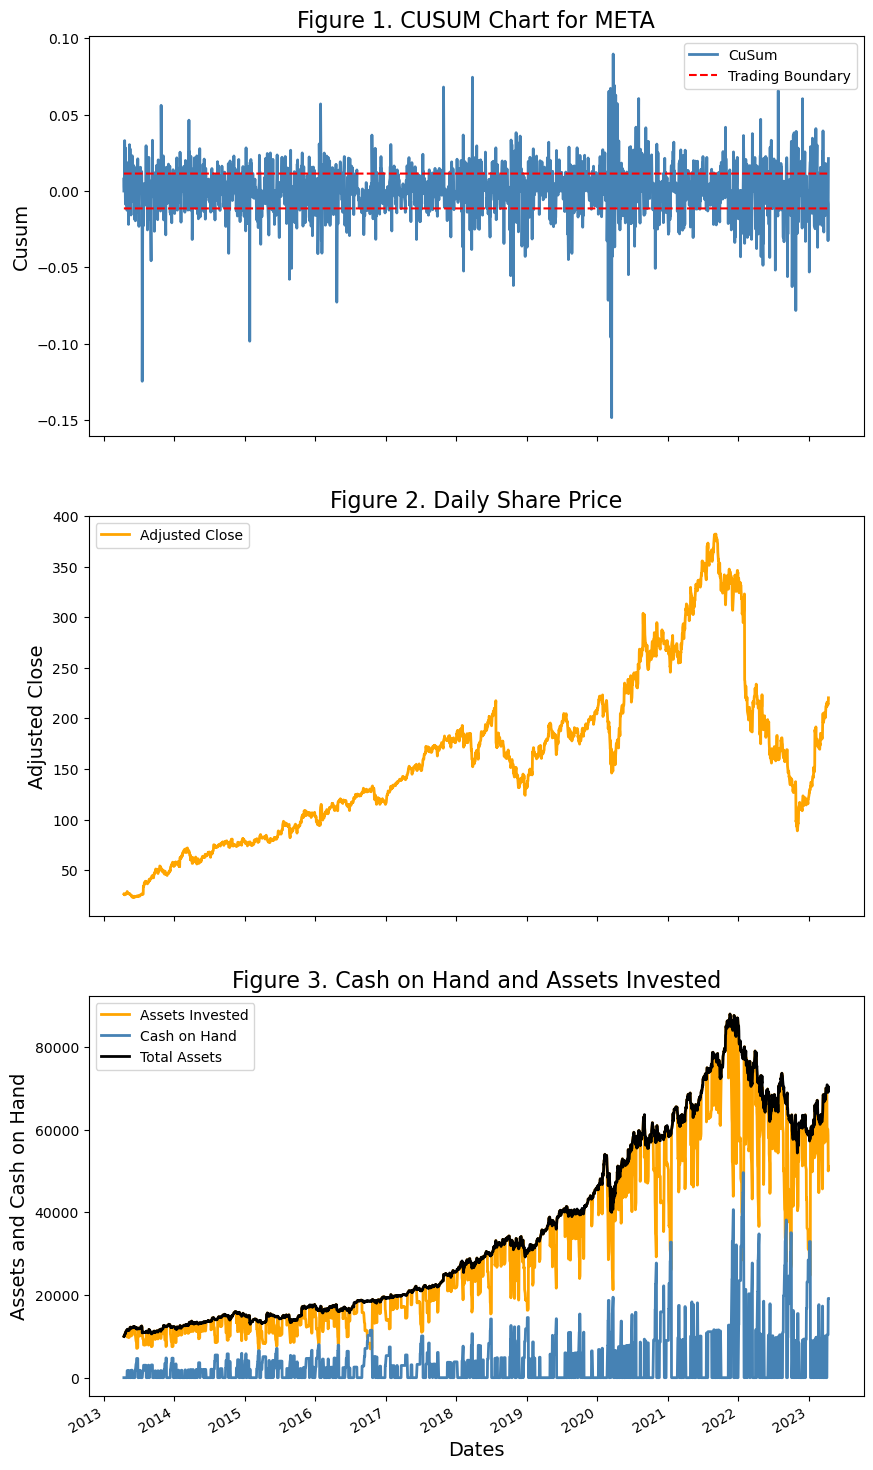

Hold    1803
Buy      374
Sell     341
Name: Instructions, dtype: int64

In [30]:
import matplotlib.pyplot as plt 
#Truncate data sets for graphs
META_growth_t = META_growth['2013-04-15':'2023-04-13']
METAdf_t = METAdf['2013-04-15':'2023-04-13']
#Configure subplots
fig, axs = plt.subplots(3, sharex = True, figsize=(10,20))
#Specifying cusum plot
axs[0].plot(META_growth_t['S'], label='CuSum', color='steelblue', linewidth = 2)
axs[0].plot(META_growth_t['Upper'], label='Trading Boundary', color='red', linestyle='dashed')
axs[0].plot(META_growth_t['Lower'], color='red', linestyle='dashed')
#Specifying share price plot
axs[1].plot(METAdf_t['Adj Close'], label="Adjusted Close", color='orange', linewidth=2)
#Specifying share price plot
axs[2].plot(META_growth_t['Assets Invested'], label="Assets Invested", color='orange', linewidth=2)
axs[2].plot(META_growth_t['Cash on Hand'], label="Cash on Hand", color='steelblue', linewidth=2)
axs[2].plot(META_growth_t['Total Assets'], label="Total Assets", color='black', linewidth=2)
#add legends for both figures.
axs[0].legend()
axs[1].legend()
axs[2].legend()

#add axis labels and titles
axs[0].set_ylabel('Cusum', fontsize=14)
axs[1].set_ylabel('Adjusted Close', fontsize=14)
axs[2].set_ylabel('Assets and Cash on Hand', fontsize=14)
plt.xlabel('Dates', fontsize=14)
axs[0].set_title('Figure 1. CUSUM Chart for META', fontsize = 16)
axs[1].set_title('Figure 2. Daily Share Price', fontsize = 16)
axs[2].set_title('Figure 3. Cash on Hand and Assets Invested', fontsize = 16)
plt.gcf().autofmt_xdate()
#display plot
plt.show()
META_growth['Instructions'].value_counts()

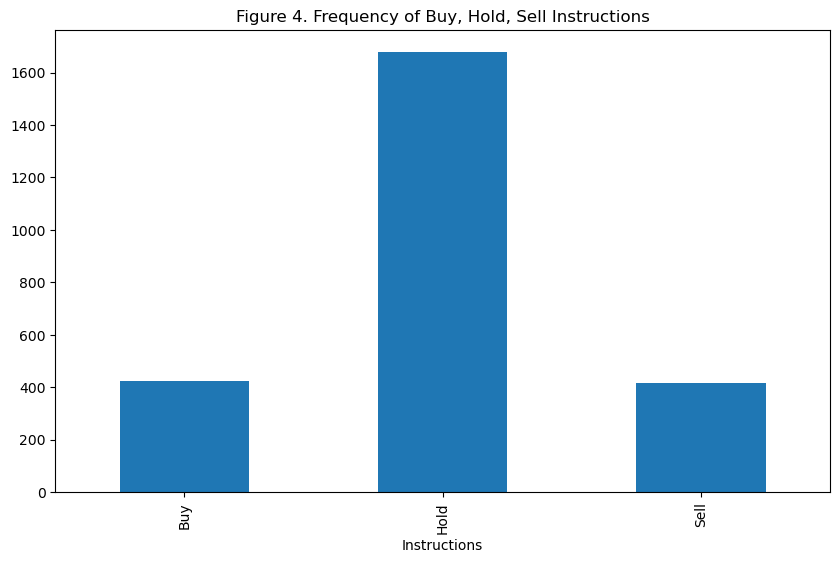

In [18]:
#Counting Frequencies of Buy, Hold, Sell Instructions
count = META_growth_t.groupby(['Instructions']).count()
#Convert one column to a dataframe
countdf = pd.DataFrame(data=count['S'])
countdf.plot.bar(figsize = (10,6), title="Figure 4. Frequency of Buy, Hold, Sell Instructions", legend=False)
plt.show()

## META H2

0.0011409253863709644
Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of 2.28% is 18.43%
The annualized rate of growth using a hold strategy is 23.58%


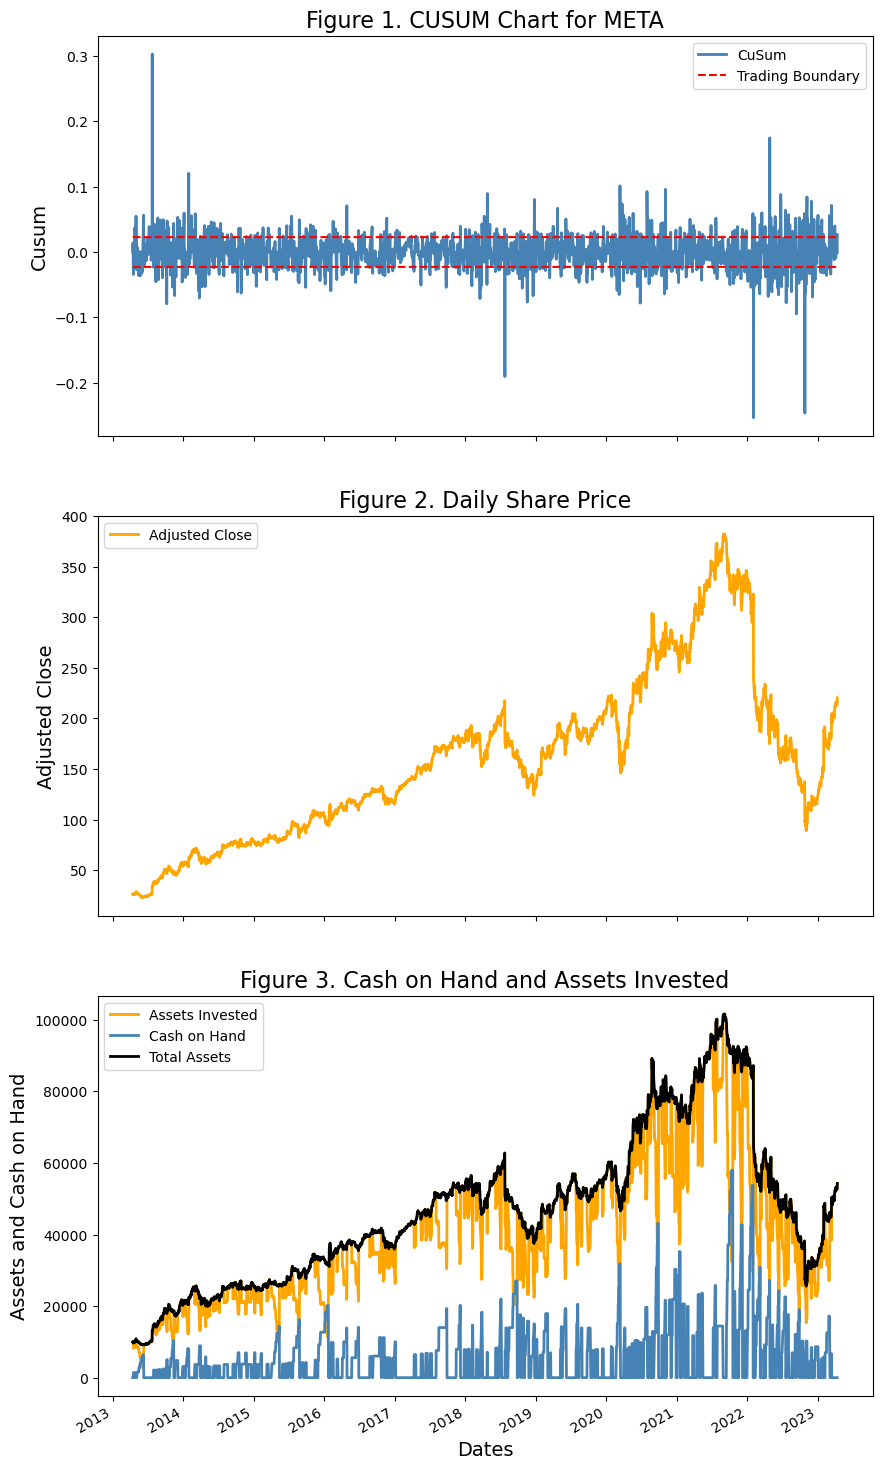

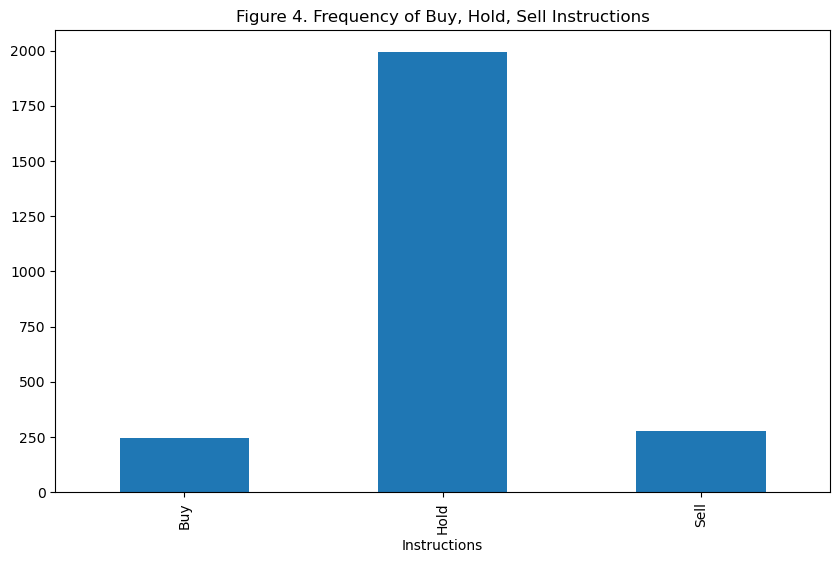

In [35]:
# Step 3 Calculate the mean growth rate and convert growth rate data to a list for manipulation.
# For the sake of this exercise, let k = the mean growth rate.
k1 = META_growth['Adj Close'].mean()
print(k1)
# For the sake of this exercise, we will consider various thresholds for h. There are more sophisicated methods for setting h,
# but the article upon which this is based proposes simple thresholds, including 10k, 20k, 30k, et cetera.
h1 = 10*k1
h2 = 20*k1
h3 = 30*k1
h4 = 60*k1
# We will for ease of calculation, convert our dataframe column to a list.
Adj_Close1 = META_growth['Adj Close'].tolist()

# Step 4 
# Initialize your cumulative sum
S = [0]
# Initialize your Instructions
I = ['Hold']
# Initialize assets invested
AINV = [10000]
# Initialize cash on hand.
CHELD = [0]
# Parameter on the share of cash on hand to use in case to buy if thresholds are reached.
bshare = 1
# Parameter on the share of assets to sell if thresholds are reached.
sshare = 0.15
# Set threshold
thresh = h2
# We will perform these calculations interatively.
for t in range(1, len(Adj_Close)):
    if len(S) == 1: #For the first run though, we simply calculate the value. This avoids an out of index problem.
        Snew = S[t-1] + (Adj_Close1[t] - k1) #This is the sum accumulator.
        S.append(Snew) # Populate the S list.
        I.append('Hold') # Populate Instruction List
        Avalue = AINV[t-1]*(1+Adj_Close1[t]) #Increase the value of existing assets by the amount of the growth in the stock.
        AINV.append(Avalue) #Populate the assets invested file.
        CHchanged = CHELD[t-1]
        CHELD.append(CHchanged)
    else:
        if S[t-1] >= thresh: # Instructions if the upper threshold is passed. (Buy)
            Snew = 0 # Revert value back to zero
            S.append(Snew) 
            I.append('Buy')
            Avalue = AINV[t-1]*(1+Adj_Close1[t]) + bshare*CHELD[t-1] #Increase the value of existing assets by the amount of the growth in the stock. Add any additional purchases.
            CHchanged = (1- bshare)*CHELD[t-1] #Adjust the cash on hand
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        elif S[t-1] <= -thresh: # Instructions if the lower threshold is passed. (Sell)
            Snew = 0
            S.append(Snew)
            I.append('Sell')
            Avalue = AINV[t-1]*(1+Adj_Close1[t]) - sshare*AINV[t-1]
            CHchanged = CHELD[t-1] + sshare*AINV[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        else:
            Snew = S[t-1] + (Adj_Close1[t] - k1) # Instructions to hold are passed because the result is within boundaries.
            S.append(Snew)
            I.append('Hold')
            Avalue = AINV[t-1]*(1+Adj_Close1[t])
            CHchanged = CHELD[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
            
# Initialize assets invested
AINV2_1 = [10000]
for k in range(1, len(Adj_Close)):
       Avalue2_1 = AINV2_1[k-1]*(1+Adj_Close1[k]) #Increase the value of existing assets by the amount of the growth in the stock.
       AINV2_1.append(Avalue2_1) #Populate the assets invested file.
    
    
# These steps are just adding columns to the data set.
META_growth['S'] = S
META_growth['Upper'] = h2
META_growth['Lower'] = -h2
META_growth['Instructions'] = I
META_growth['Assets Invested'] = AINV
META_growth['Cash on Hand'] = CHELD
META_growth['Total Assets'] = META_growth['Assets Invested'] + META_growth['Cash on Hand']
META_growth['Alt Assets'] = AINV2_1 
META_growth

# Make a copy of the data frame.
METAdf_year = META_growth.copy(deep = True)
# Reset the index on the copy to get the actual dates as a column.
METAdf_year.reset_index(inplace=True)
# Create a number column for just year
METAdf_year['year'] = pd.DatetimeIndex(METAdf_year['Date']).year
# Find the unique values in a column
years = METAdf_year.year.unique()
# Count total years from length of array
n_years = len(years) - 1
# Calculate the approximate annual growth rate of total assets
approx_growth = (META_growth['Total Assets'][len(META_growth['Total Assets']) - 1]/META_growth['Total Assets'][0])**(1/n_years) - 1
approx_growth_alt = (META_growth['Alt Assets'][len(META_growth['Alt Assets']) - 1]/META_growth['Alt Assets'][0])**(1/n_years) - 1
print("Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of {:.2%} is {:.2%}".format(thresh, approx_growth))
print("The annualized rate of growth using a hold strategy is {:.2%}".format(approx_growth_alt))

import matplotlib.pyplot as plt 
#Truncate data sets for graphs
META_growth_t = META_growth['2013-04-15':'2023-04-13']
METAdf_t = METAdf['2013-04-15':'2023-04-13']
#Configure subplots
fig, axs = plt.subplots(3, sharex = True, figsize=(10,20))
#Specifying cusum plot
axs[0].plot(META_growth_t['S'], label='CuSum', color='steelblue', linewidth = 2)
axs[0].plot(META_growth_t['Upper'], label='Trading Boundary', color='red', linestyle='dashed')
axs[0].plot(META_growth_t['Lower'], color='red', linestyle='dashed')
#Specifying share price plot
axs[1].plot(METAdf_t['Adj Close'], label="Adjusted Close", color='orange', linewidth=2)
#Specifying share price plot
axs[2].plot(META_growth_t['Assets Invested'], label="Assets Invested", color='orange', linewidth=2)
axs[2].plot(META_growth_t['Cash on Hand'], label="Cash on Hand", color='steelblue', linewidth=2)
axs[2].plot(META_growth_t['Total Assets'], label="Total Assets", color='black', linewidth=2)
#add legends for both figures.
axs[0].legend()
axs[1].legend()
axs[2].legend()

#add axis labels and titles
axs[0].set_ylabel('Cusum', fontsize=14)
axs[1].set_ylabel('Adjusted Close', fontsize=14)
axs[2].set_ylabel('Assets and Cash on Hand', fontsize=14)
plt.xlabel('Dates', fontsize=14)
axs[0].set_title('Figure 1. CUSUM Chart for META', fontsize = 16)
axs[1].set_title('Figure 2. Daily Share Price', fontsize = 16)
axs[2].set_title('Figure 3. Cash on Hand and Assets Invested', fontsize = 16)
plt.gcf().autofmt_xdate()
#display plot
plt.show()
META_growth['Instructions'].value_counts()

#Counting Frequencies of Buy, Hold, Sell Instructions
count = META_growth_t.groupby(['Instructions']).count()
#Convert one column to a dataframe
countdf = pd.DataFrame(data=count['S'])
countdf.plot.bar(figsize = (10,6), title="Figure 4. Frequency of Buy, Hold, Sell Instructions", legend=False)
plt.show()

## META H3

0.0011409253863709644
Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of 3.42% is 21.45%
The annualized rate of growth using a hold strategy is 23.58%


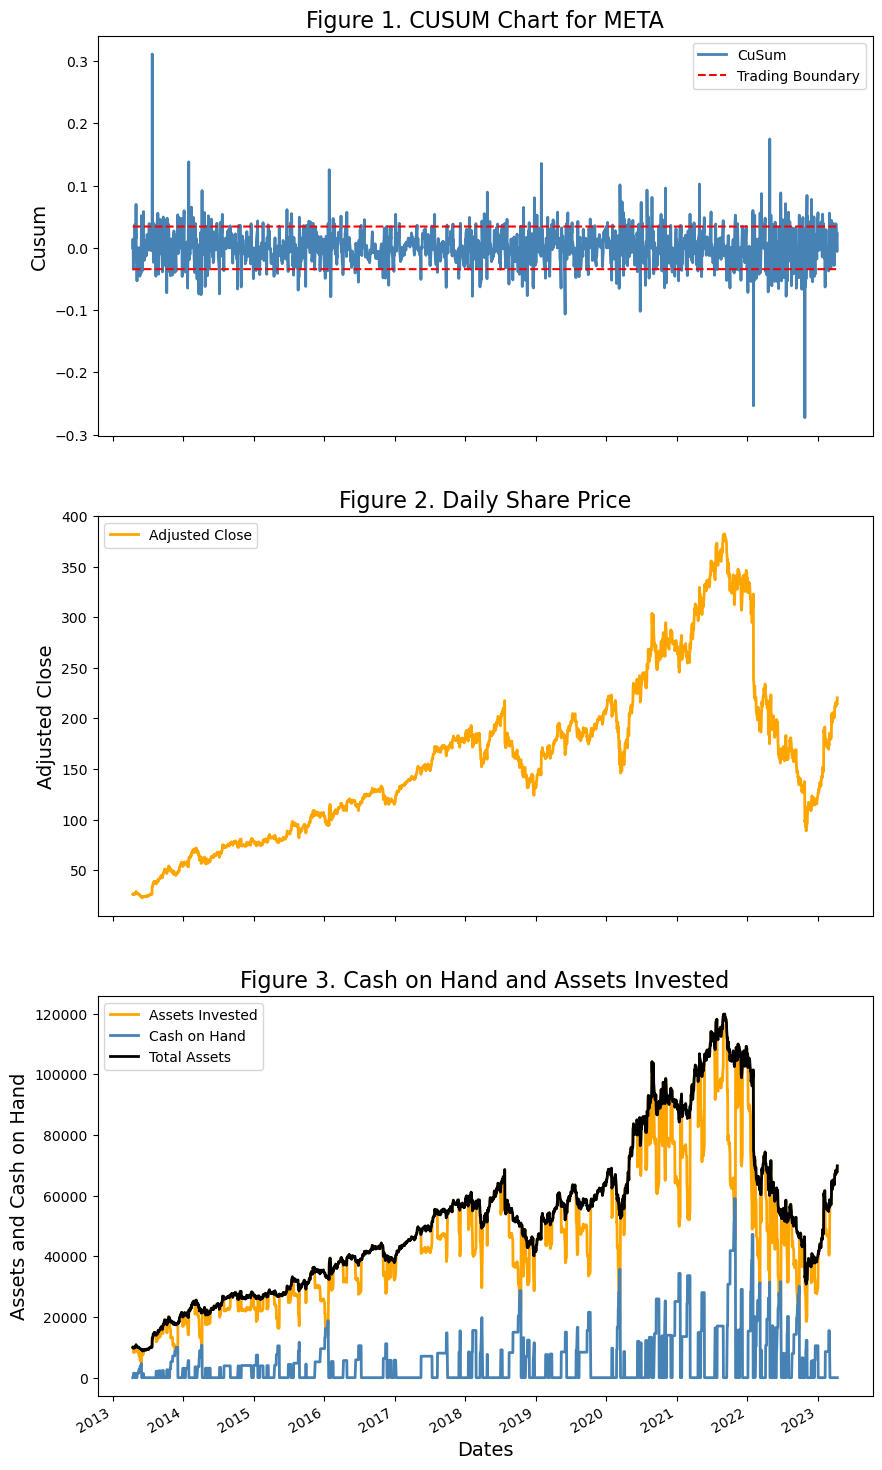

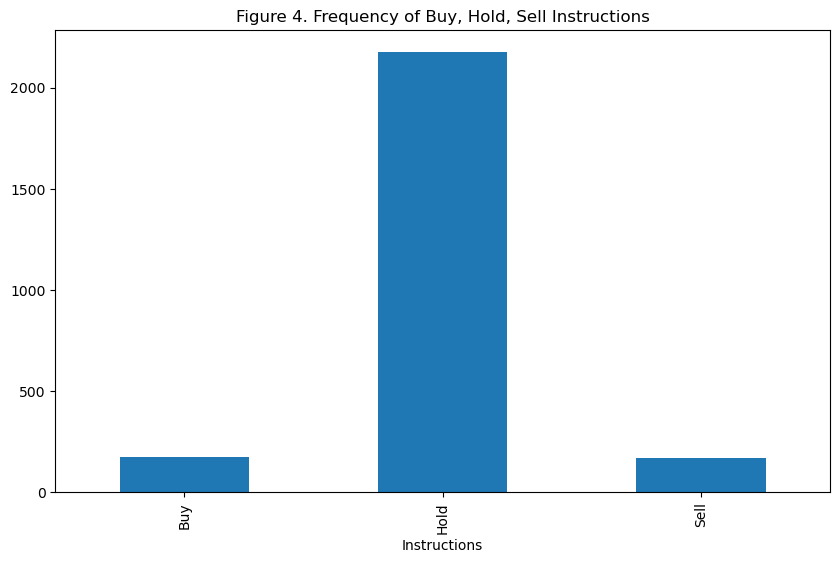

In [36]:
# Step 3 Calculate the mean growth rate and convert growth rate data to a list for manipulation.
# For the sake of this exercise, let k = the mean growth rate.
k1 = META_growth['Adj Close'].mean()
print(k1)
# For the sake of this exercise, we will consider various thresholds for h. There are more sophisicated methods for setting h,
# but the article upon which this is based proposes simple thresholds, including 10k, 20k, 30k, et cetera.
h1 = 10*k1
h2 = 20*k1
h3 = 30*k1
h4 = 60*k1
# We will for ease of calculation, convert our dataframe column to a list.
Adj_Close1 = META_growth['Adj Close'].tolist()

# Step 4 
# Initialize your cumulative sum
S = [0]
# Initialize your Instructions
I = ['Hold']
# Initialize assets invested
AINV = [10000]
# Initialize cash on hand.
CHELD = [0]
# Parameter on the share of cash on hand to use in case to buy if thresholds are reached.
bshare = 1
# Parameter on the share of assets to sell if thresholds are reached.
sshare = 0.15
# Set threshold
thresh = h3
# We will perform these calculations interatively.
for t in range(1, len(Adj_Close)):
    if len(S) == 1: #For the first run though, we simply calculate the value. This avoids an out of index problem.
        Snew = S[t-1] + (Adj_Close1[t] - k1) #This is the sum accumulator.
        S.append(Snew) # Populate the S list.
        I.append('Hold') # Populate Instruction List
        Avalue = AINV[t-1]*(1+Adj_Close1[t]) #Increase the value of existing assets by the amount of the growth in the stock.
        AINV.append(Avalue) #Populate the assets invested file.
        CHchanged = CHELD[t-1]
        CHELD.append(CHchanged)
    else:
        if S[t-1] >= thresh: # Instructions if the upper threshold is passed. (Buy)
            Snew = 0 # Revert value back to zero
            S.append(Snew) 
            I.append('Buy')
            Avalue = AINV[t-1]*(1+Adj_Close1[t]) + bshare*CHELD[t-1] #Increase the value of existing assets by the amount of the growth in the stock. Add any additional purchases.
            CHchanged = (1- bshare)*CHELD[t-1] #Adjust the cash on hand
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        elif S[t-1] <= -thresh: # Instructions if the lower threshold is passed. (Sell)
            Snew = 0
            S.append(Snew)
            I.append('Sell')
            Avalue = AINV[t-1]*(1+Adj_Close1[t]) - sshare*AINV[t-1]
            CHchanged = CHELD[t-1] + sshare*AINV[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        else:
            Snew = S[t-1] + (Adj_Close1[t] - k1) # Instructions to hold are passed because the result is within boundaries.
            S.append(Snew)
            I.append('Hold')
            Avalue = AINV[t-1]*(1+Adj_Close1[t])
            CHchanged = CHELD[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
            
# Initialize assets invested
AINV2_1 = [10000]
for k in range(1, len(Adj_Close)):
       Avalue2_1 = AINV2_1[k-1]*(1+Adj_Close1[k]) #Increase the value of existing assets by the amount of the growth in the stock.
       AINV2_1.append(Avalue2_1) #Populate the assets invested file.
    
    
# These steps are just adding columns to the data set.
META_growth['S'] = S
META_growth['Upper'] = h3
META_growth['Lower'] = -h3
META_growth['Instructions'] = I
META_growth['Assets Invested'] = AINV
META_growth['Cash on Hand'] = CHELD
META_growth['Total Assets'] = META_growth['Assets Invested'] + META_growth['Cash on Hand']
META_growth['Alt Assets'] = AINV2_1 
META_growth

# Make a copy of the data frame.
METAdf_year = META_growth.copy(deep = True)
# Reset the index on the copy to get the actual dates as a column.
METAdf_year.reset_index(inplace=True)
# Create a number column for just year
METAdf_year['year'] = pd.DatetimeIndex(METAdf_year['Date']).year
# Find the unique values in a column
years = METAdf_year.year.unique()
# Count total years from length of array
n_years = len(years) - 1
# Calculate the approximate annual growth rate of total assets
approx_growth = (META_growth['Total Assets'][len(META_growth['Total Assets']) - 1]/META_growth['Total Assets'][0])**(1/n_years) - 1
approx_growth_alt = (META_growth['Alt Assets'][len(META_growth['Alt Assets']) - 1]/META_growth['Alt Assets'][0])**(1/n_years) - 1
print("Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of {:.2%} is {:.2%}".format(thresh, approx_growth))
print("The annualized rate of growth using a hold strategy is {:.2%}".format(approx_growth_alt))

import matplotlib.pyplot as plt 
#Truncate data sets for graphs
META_growth_t = META_growth['2013-04-15':'2023-04-13']
METAdf_t = METAdf['2013-04-15':'2023-04-13']
#Configure subplots
fig, axs = plt.subplots(3, sharex = True, figsize=(10,20))
#Specifying cusum plot
axs[0].plot(META_growth_t['S'], label='CuSum', color='steelblue', linewidth = 2)
axs[0].plot(META_growth_t['Upper'], label='Trading Boundary', color='red', linestyle='dashed')
axs[0].plot(META_growth_t['Lower'], color='red', linestyle='dashed')
#Specifying share price plot
axs[1].plot(METAdf_t['Adj Close'], label="Adjusted Close", color='orange', linewidth=2)
#Specifying share price plot
axs[2].plot(META_growth_t['Assets Invested'], label="Assets Invested", color='orange', linewidth=2)
axs[2].plot(META_growth_t['Cash on Hand'], label="Cash on Hand", color='steelblue', linewidth=2)
axs[2].plot(META_growth_t['Total Assets'], label="Total Assets", color='black', linewidth=2)
#add legends for both figures.
axs[0].legend()
axs[1].legend()
axs[2].legend()

#add axis labels and titles
axs[0].set_ylabel('Cusum', fontsize=14)
axs[1].set_ylabel('Adjusted Close', fontsize=14)
axs[2].set_ylabel('Assets and Cash on Hand', fontsize=14)
plt.xlabel('Dates', fontsize=14)
axs[0].set_title('Figure 1. CUSUM Chart for META', fontsize = 16)
axs[1].set_title('Figure 2. Daily Share Price', fontsize = 16)
axs[2].set_title('Figure 3. Cash on Hand and Assets Invested', fontsize = 16)
plt.gcf().autofmt_xdate()
#display plot
plt.show()
META_growth['Instructions'].value_counts()

#Counting Frequencies of Buy, Hold, Sell Instructions
count = META_growth_t.groupby(['Instructions']).count()
#Convert one column to a dataframe
countdf = pd.DataFrame(data=count['S'])
countdf.plot.bar(figsize = (10,6), title="Figure 4. Frequency of Buy, Hold, Sell Instructions", legend=False)
plt.show()

## MICROSOFT H1

In [19]:
# Step 3 Calculate the mean growth rate and convert growth rate data to a list for manipulation.
# For the sake of this exercise, let k = the mean growth rate.
k2 = MSFT_growth['Adj Close'].mean()
# For the sake of this exercise, we will consider various thresholds for h. There are more sophisicated methods for setting h,
# but the article upon which this is based proposes simple thresholds, including 10k, 20k, 30k, et cetera.
h1 = 10*k2
h2 = 20*k2
h3 = 30*k2
h4 = 60*k2
# We will for ease of calculation, convert our dataframe column to a list.
Adj_Close2 = MSFT_growth['Adj Close'].tolist()

In [20]:
# Step 4 
# Initialize your cumulative sum
S = [0]
# Initialize your Instructions
I = ['Hold']
# Initialize assets invested
AINV = [10000]
# Initialize cash on hand.
CHELD = [0]
# Parameter on the share of cash on hand to use in case to buy if thresholds are reached.
bshare = 1
# Parameter on the share of assets to sell if thresholds are reached.
sshare = 0.15
# Set threshold
thresh = h1
# We will perform these calculations interatively.
for t in range(1, len(Adj_Close)):
    if len(S) == 1: #For the first run though, we simply calculate the value. This avoids an out of index problem.
        Snew = S[t-1] + (Adj_Close2[t] - k2) #This is the sum accumulator.
        S.append(Snew) # Populate the S list.
        I.append('Hold') # Populate Instruction List
        Avalue = AINV[t-1]*(1+Adj_Close2[t]) #Increase the value of existing assets by the amount of the growth in the stock.
        AINV.append(Avalue) #Populate the assets invested file.
        CHchanged = CHELD[t-1]
        CHELD.append(CHchanged)
    else:
        if S[t-1] >= thresh: # Instructions if the upper threshold is passed. (Buy)
            Snew = 0 # Revert value back to zero
            S.append(Snew) 
            I.append('Buy')
            Avalue = AINV[t-1]*(1+Adj_Close2[t]) + bshare*CHELD[t-1] #Increase the value of existing assets by the amount of the growth in the stock. Add any additional purchases.
            CHchanged = (1- bshare)*CHELD[t-1] #Adjust the cash on hand
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        elif S[t-1] <= -thresh: # Instructions if the lower threshold is passed. (Sell)
            Snew = 0
            S.append(Snew)
            I.append('Sell')
            Avalue = AINV[t-1]*(1+Adj_Close2[t]) - sshare*AINV[t-1]
            CHchanged = CHELD[t-1] + sshare*AINV[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        else:
            Snew = S[t-1] + (Adj_Close2[t] - k2) # Instructions to hold are passed because the result is within boundaries.
            S.append(Snew)
            I.append('Hold')
            Avalue = AINV[t-1]*(1+Adj_Close2[t])
            CHchanged = CHELD[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)

In [21]:
# Initialize assets invested
AINV2_2 = [10000]
for k in range(1, len(Adj_Close)):
       Avalue2_2 = AINV2_2[k-1]*(1+Adj_Close2[k]) #Increase the value of existing assets by the amount of the growth in the stock.
       AINV2_2.append(Avalue2_2) #Populate the assets invested file.

In [22]:
# These steps are just adding columns to the data set.
MSFT_growth['S'] = S
MSFT_growth['Upper'] = h1
MSFT_growth['Lower'] = -h1
MSFT_growth['Instructions'] = I
MSFT_growth['Assets Invested'] = AINV
MSFT_growth['Cash on Hand'] = CHELD
MSFT_growth['Total Assets'] = MSFT_growth['Assets Invested'] + MSFT_growth['Cash on Hand']
MSFT_growth['Alt Assets'] = AINV2_2 
MSFT_growth

,Open,High,Low,Close,Adj Close,Volume,S,Upper,Lower,Instructions,Assets Invested,Cash on Hand,Total Assets,Alt Assets
Date,,,,,,,,,,,,,,
2013-04-15,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.011415,-0.011415,Hold,10000.000000,0.000000,10000.000000,10000.000000
2013-04-16,0.008726,0.005521,0.006664,0.009759,0.009759,-0.062763,0.008618,0.011415,-0.011415,Hold,10097.593666,0.000000,10097.593666,10097.593666
2013-04-17,-0.001730,-0.003432,-0.003484,-0.004833,-0.004832,0.000822,0.002644,0.011415,-0.011415,Hold,10048.798724,0.000000,10048.798724,10048.798724
2013-04-18,0.003466,-0.002066,-0.003497,-0.001387,-0.001388,0.076946,0.000115,0.011415,-0.011415,Hold,10034.855271,0.000000,10034.855271,10034.855271
2013-04-19,0.023143,0.043478,0.038947,0.034040,0.034039,0.753587,0.033013,0.011415,-0.011415,Hold,10376.436674,0.000000,10376.436674,10376.436674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-06,-0.009236,0.017169,-0.003146,0.025533,0.025533,0.349221,0.000000,0.011415,-0.011415,Sell,60498.590543,10364.875057,70863.465600,122555.795143
2023-04-10,0.021186,-0.008491,0.009503,-0.007579,-0.007579,-0.223958,-0.008720,0.011415,-0.011415,Hold,60040.081154,10364.875057,70404.956211,121626.963871
2023-04-11,-0.011964,-0.012500,-0.010783,-0.022668,-0.022668,0.180652,-0.032530,0.011415,-0.011415,Hold,58679.064557,10364.875057,69043.939613,118869.867057


In [23]:
# Make a copy of the data frame.
MSFTdf_year = MSFT_growth.copy(deep = True)
# Reset the index on the copy to get the actual dates as a column.
MSFTdf_year.reset_index(inplace=True)
# Create a number column for just year
MSFTdf_year['year'] = pd.DatetimeIndex(MSFTdf_year['Date']).year
# Find the unique values in a column
years = MSFTdf_year.year.unique()
# Count total years from length of array
n_years = len(years) - 1
# Calculate the approximate annual growth rate of total assets
approx_growth = (MSFT_growth['Total Assets'][len(MSFT_growth['Total Assets']) - 1]/MSFT_growth['Total Assets'][0])**(1/n_years) - 1
approx_growth_alt = (MSFT_growth['Alt Assets'][len(MSFT_growth['Alt Assets']) - 1]/MSFT_growth['Alt Assets'][0])**(1/n_years) - 1
print("Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of {:.2%} is {:.2%}".format(thresh, approx_growth))
print("The annualized rate of growth using a hold strategy is {:.2%}".format(approx_growth_alt))

Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of 1.14% is 21.53%
The annualized rate of growth using a hold strategy is 28.40%


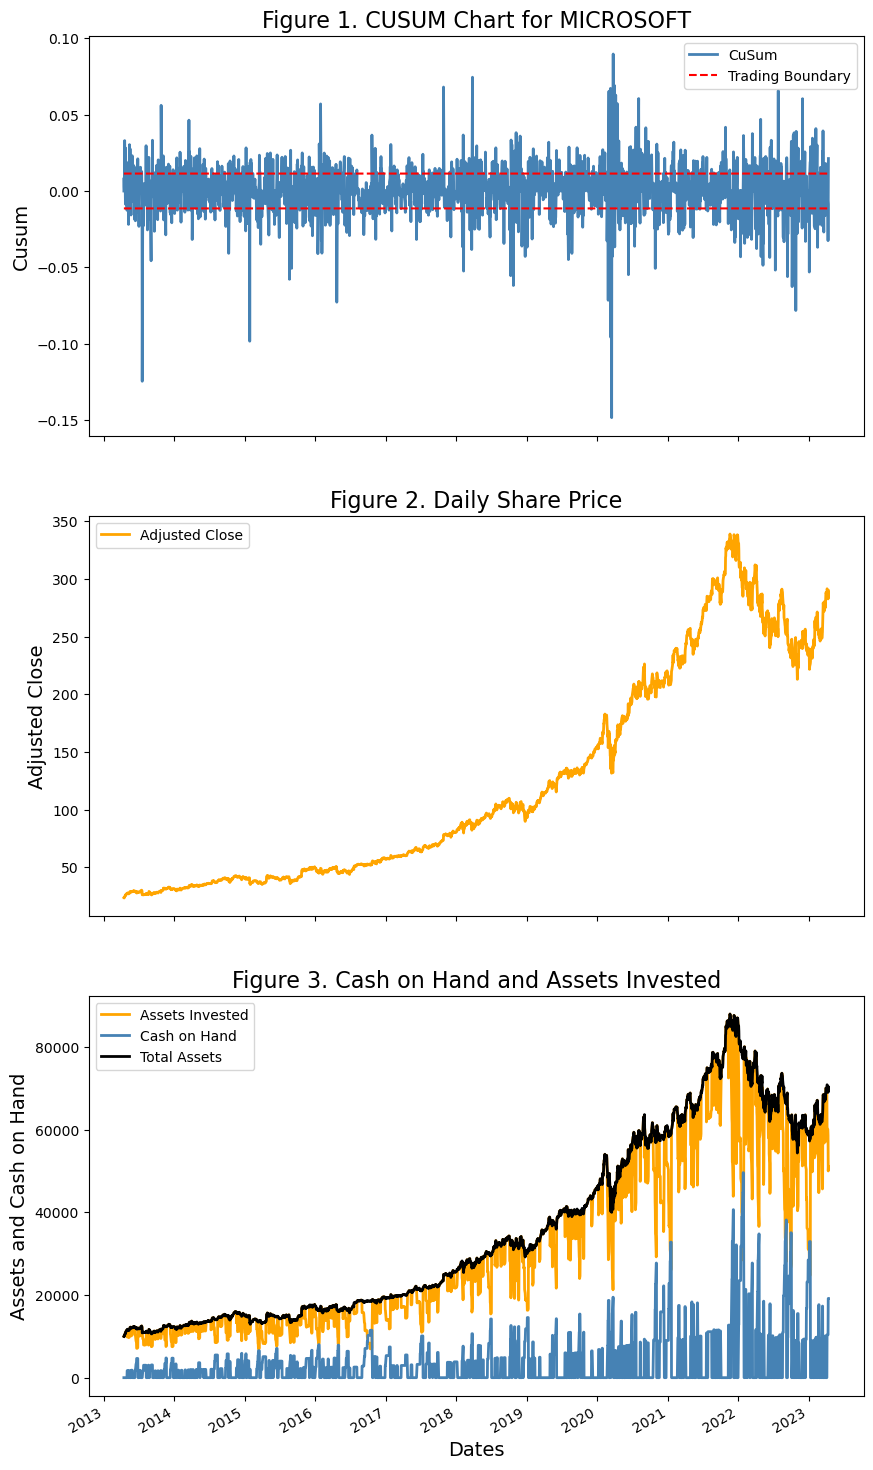

Hold    1803
Buy      374
Sell     341
Name: Instructions, dtype: int64

In [25]:
import matplotlib.pyplot as plt 
#Truncate data sets for graphs
MSFT_growth_t = MSFT_growth['2013-04-15':'2023-04-13']
MSFTdf_t = MSFTdf['2013-04-15':'2023-04-13']
#Configure subplots
fig, axs = plt.subplots(3, sharex = True, figsize=(10,20))
#Specifying cusum plot
axs[0].plot(MSFT_growth_t['S'], label='CuSum', color='steelblue', linewidth = 2)
axs[0].plot(MSFT_growth_t['Upper'], label='Trading Boundary', color='red', linestyle='dashed')
axs[0].plot(MSFT_growth_t['Lower'], color='red', linestyle='dashed')
#Specifying share price plot
axs[1].plot(MSFTdf_t['Adj Close'], label="Adjusted Close", color='orange', linewidth=2)
#Specifying share price plot
axs[2].plot(MSFT_growth_t['Assets Invested'], label="Assets Invested", color='orange', linewidth=2)
axs[2].plot(MSFT_growth_t['Cash on Hand'], label="Cash on Hand", color='steelblue', linewidth=2)
axs[2].plot(MSFT_growth_t['Total Assets'], label="Total Assets", color='black', linewidth=2)
#add legends for both figures.
axs[0].legend()
axs[1].legend()
axs[2].legend()

#add axis labels and titles
axs[0].set_ylabel('Cusum', fontsize=14)
axs[1].set_ylabel('Adjusted Close', fontsize=14)
axs[2].set_ylabel('Assets and Cash on Hand', fontsize=14)
plt.xlabel('Dates', fontsize=14)
axs[0].set_title('Figure 1. CUSUM Chart for MICROSOFT', fontsize = 16)
axs[1].set_title('Figure 2. Daily Share Price', fontsize = 16)
axs[2].set_title('Figure 3. Cash on Hand and Assets Invested', fontsize = 16)
plt.gcf().autofmt_xdate()
#display plot
plt.show()
MSFT_growth['Instructions'].value_counts()

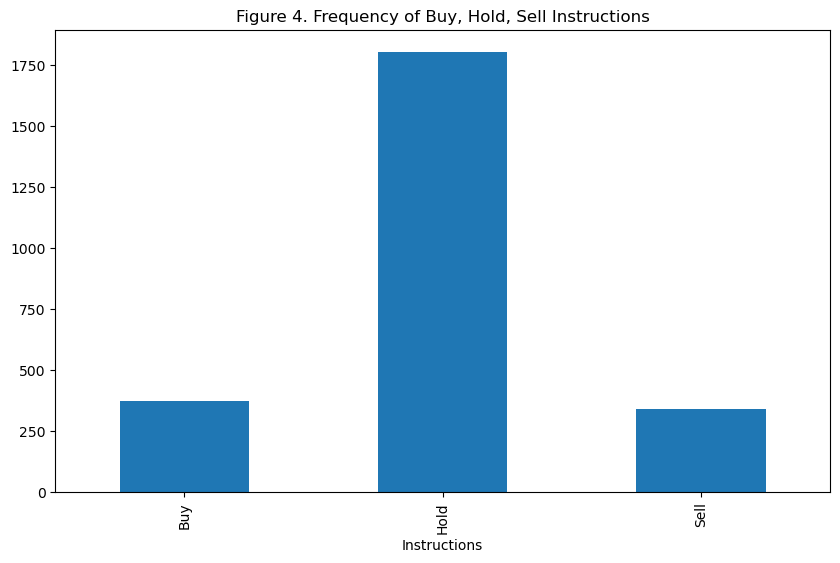

In [26]:
#Counting Frequencies of Buy, Hold, Sell Instructions
count = MSFT_growth_t.groupby(['Instructions']).count()
#Convert one column to a dataframe
countdf = pd.DataFrame(data=count['S'])
countdf.plot.bar(figsize = (10,6), title="Figure 4. Frequency of Buy, Hold, Sell Instructions", legend=False)
plt.show()

## MICROSOFT H2

Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of 2.28% is 22.17%
The annualized rate of growth using a hold strategy is 28.40%


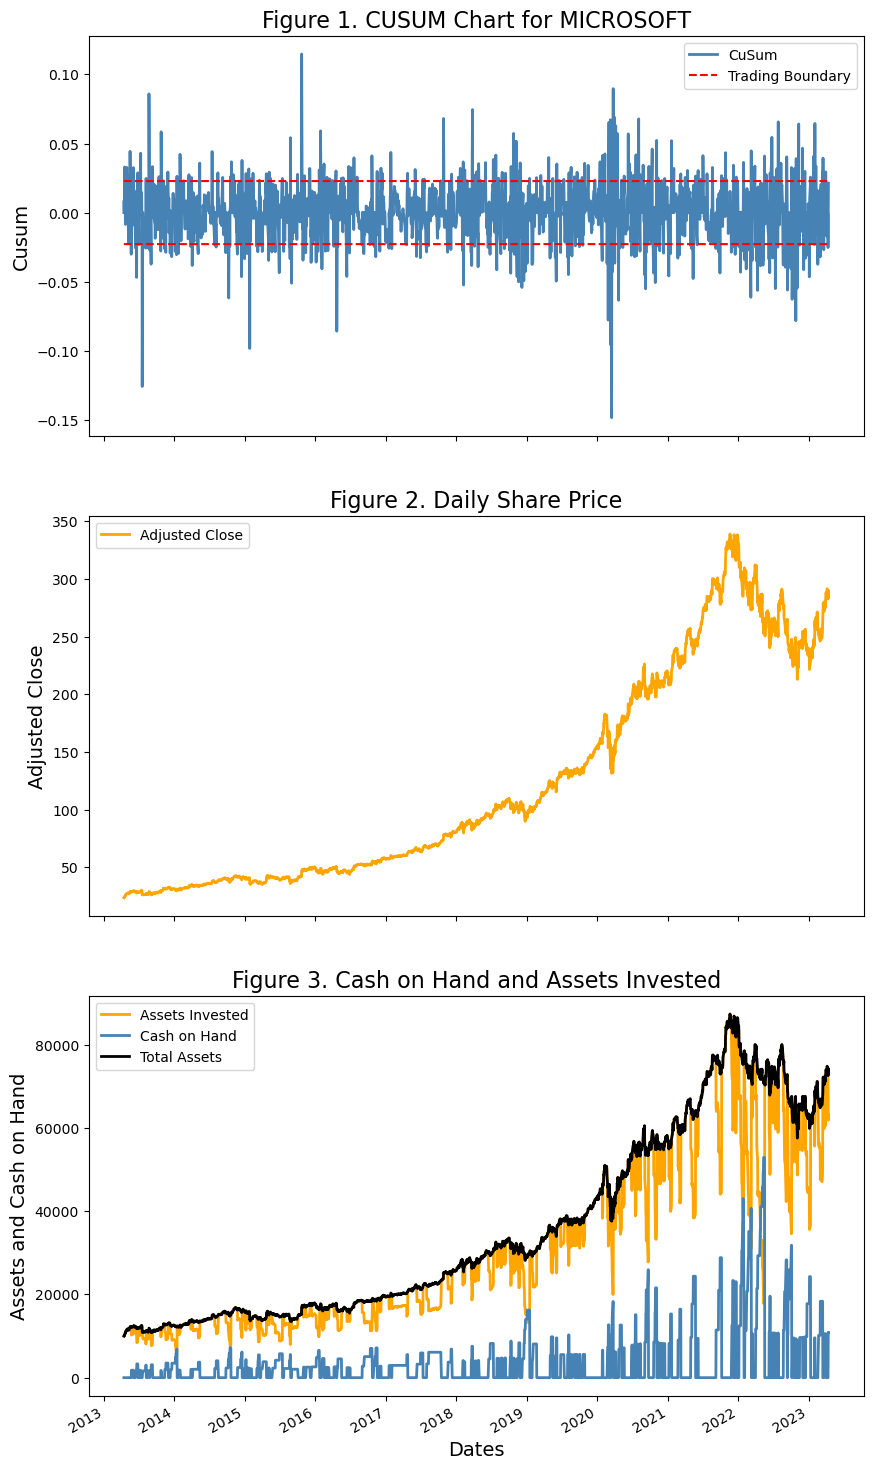

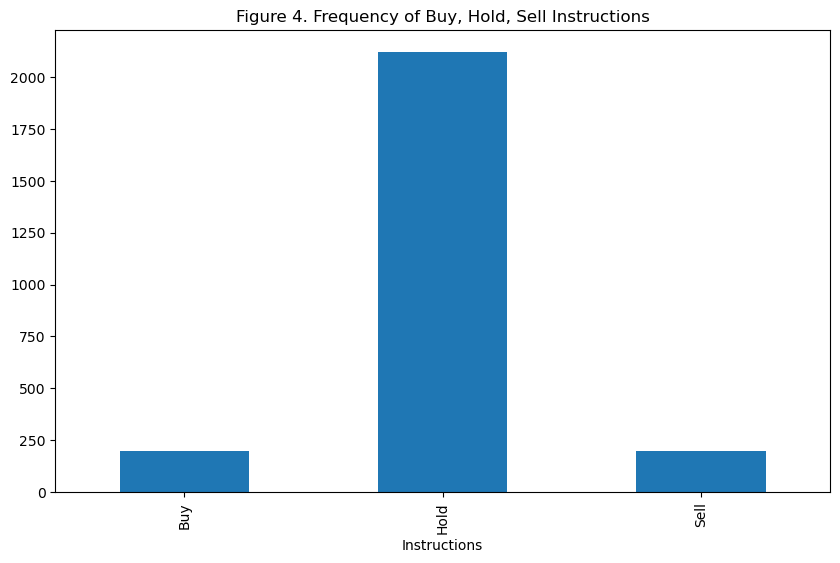

In [38]:
# Step 3 Calculate the mean growth rate and convert growth rate data to a list for manipulation.
# For the sake of this exercise, let k = the mean growth rate.
k2 = MSFT_growth['Adj Close'].mean()
# For the sake of this exercise, we will consider various thresholds for h. There are more sophisicated methods for setting h,
# but the article upon which this is based proposes simple thresholds, including 10k, 20k, 30k, et cetera.
h1 = 10*k2
h2 = 20*k2
h3 = 30*k2
h4 = 60*k2
# We will for ease of calculation, convert our dataframe column to a list.
Adj_Close2 = MSFT_growth['Adj Close'].tolist()

# Step 4 
# Initialize your cumulative sum
S = [0]
# Initialize your Instructions
I = ['Hold']
# Initialize assets invested
AINV = [10000]
# Initialize cash on hand.
CHELD = [0]
# Parameter on the share of cash on hand to use in case to buy if thresholds are reached.
bshare = 1
# Parameter on the share of assets to sell if thresholds are reached.
sshare = 0.15
# Set threshold
thresh = h2
# We will perform these calculations interatively.
for t in range(1, len(Adj_Close)):
    if len(S) == 1: #For the first run though, we simply calculate the value. This avoids an out of index problem.
        Snew = S[t-1] + (Adj_Close2[t] - k2) #This is the sum accumulator.
        S.append(Snew) # Populate the S list.
        I.append('Hold') # Populate Instruction List
        Avalue = AINV[t-1]*(1+Adj_Close2[t]) #Increase the value of existing assets by the amount of the growth in the stock.
        AINV.append(Avalue) #Populate the assets invested file.
        CHchanged = CHELD[t-1]
        CHELD.append(CHchanged)
    else:
        if S[t-1] >= thresh: # Instructions if the upper threshold is passed. (Buy)
            Snew = 0 # Revert value back to zero
            S.append(Snew) 
            I.append('Buy')
            Avalue = AINV[t-1]*(1+Adj_Close2[t]) + bshare*CHELD[t-1] #Increase the value of existing assets by the amount of the growth in the stock. Add any additional purchases.
            CHchanged = (1- bshare)*CHELD[t-1] #Adjust the cash on hand
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        elif S[t-1] <= -thresh: # Instructions if the lower threshold is passed. (Sell)
            Snew = 0
            S.append(Snew)
            I.append('Sell')
            Avalue = AINV[t-1]*(1+Adj_Close2[t]) - sshare*AINV[t-1]
            CHchanged = CHELD[t-1] + sshare*AINV[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        else:
            Snew = S[t-1] + (Adj_Close2[t] - k2) # Instructions to hold are passed because the result is within boundaries.
            S.append(Snew)
            I.append('Hold')
            Avalue = AINV[t-1]*(1+Adj_Close2[t])
            CHchanged = CHELD[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
            
# Initialize assets invested
AINV2_2 = [10000]
for k in range(1, len(Adj_Close)):
       Avalue2_2 = AINV2_2[k-1]*(1+Adj_Close2[k]) #Increase the value of existing assets by the amount of the growth in the stock.
       AINV2_2.append(Avalue2_2) #Populate the assets invested file.
    
# These steps are just adding columns to the data set.
MSFT_growth['S'] = S
MSFT_growth['Upper'] = h2
MSFT_growth['Lower'] = -h2
MSFT_growth['Instructions'] = I
MSFT_growth['Assets Invested'] = AINV
MSFT_growth['Cash on Hand'] = CHELD
MSFT_growth['Total Assets'] = MSFT_growth['Assets Invested'] + MSFT_growth['Cash on Hand']
MSFT_growth['Alt Assets'] = AINV2_2 
MSFT_growth

# Make a copy of the data frame.
MSFTdf_year = MSFT_growth.copy(deep = True)
# Reset the index on the copy to get the actual dates as a column.
MSFTdf_year.reset_index(inplace=True)
# Create a number column for just year
MSFTdf_year['year'] = pd.DatetimeIndex(MSFTdf_year['Date']).year
# Find the unique values in a column
years = MSFTdf_year.year.unique()
# Count total years from length of array
n_years = len(years) - 1
# Calculate the approximate annual growth rate of total assets
approx_growth = (MSFT_growth['Total Assets'][len(MSFT_growth['Total Assets']) - 1]/MSFT_growth['Total Assets'][0])**(1/n_years) - 1
approx_growth_alt = (MSFT_growth['Alt Assets'][len(MSFT_growth['Alt Assets']) - 1]/MSFT_growth['Alt Assets'][0])**(1/n_years) - 1
print("Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of {:.2%} is {:.2%}".format(thresh, approx_growth))
print("The annualized rate of growth using a hold strategy is {:.2%}".format(approx_growth_alt))

import matplotlib.pyplot as plt 
#Truncate data sets for graphs
MSFT_growth_t = MSFT_growth['2013-04-15':'2023-04-13']
MSFTdf_t = MSFTdf['2013-04-15':'2023-04-13']
#Configure subplots
fig, axs = plt.subplots(3, sharex = True, figsize=(10,20))
#Specifying cusum plot
axs[0].plot(MSFT_growth_t['S'], label='CuSum', color='steelblue', linewidth = 2)
axs[0].plot(MSFT_growth_t['Upper'], label='Trading Boundary', color='red', linestyle='dashed')
axs[0].plot(MSFT_growth_t['Lower'], color='red', linestyle='dashed')
#Specifying share price plot
axs[1].plot(MSFTdf_t['Adj Close'], label="Adjusted Close", color='orange', linewidth=2)
#Specifying share price plot
axs[2].plot(MSFT_growth_t['Assets Invested'], label="Assets Invested", color='orange', linewidth=2)
axs[2].plot(MSFT_growth_t['Cash on Hand'], label="Cash on Hand", color='steelblue', linewidth=2)
axs[2].plot(MSFT_growth_t['Total Assets'], label="Total Assets", color='black', linewidth=2)
#add legends for both figures.
axs[0].legend()
axs[1].legend()
axs[2].legend()

#add axis labels and titles
axs[0].set_ylabel('Cusum', fontsize=14)
axs[1].set_ylabel('Adjusted Close', fontsize=14)
axs[2].set_ylabel('Assets and Cash on Hand', fontsize=14)
plt.xlabel('Dates', fontsize=14)
axs[0].set_title('Figure 1. CUSUM Chart for MICROSOFT', fontsize = 16)
axs[1].set_title('Figure 2. Daily Share Price', fontsize = 16)
axs[2].set_title('Figure 3. Cash on Hand and Assets Invested', fontsize = 16)
plt.gcf().autofmt_xdate()
#display plot
plt.show()
MSFT_growth['Instructions'].value_counts()

#Counting Frequencies of Buy, Hold, Sell Instructions
count = MSFT_growth_t.groupby(['Instructions']).count()
#Convert one column to a dataframe
countdf = pd.DataFrame(data=count['S'])
countdf.plot.bar(figsize = (10,6), title="Figure 4. Frequency of Buy, Hold, Sell Instructions", legend=False)
plt.show()

## MICROSOFT H3

Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of 3.42% is 21.87%
The annualized rate of growth using a hold strategy is 28.40%


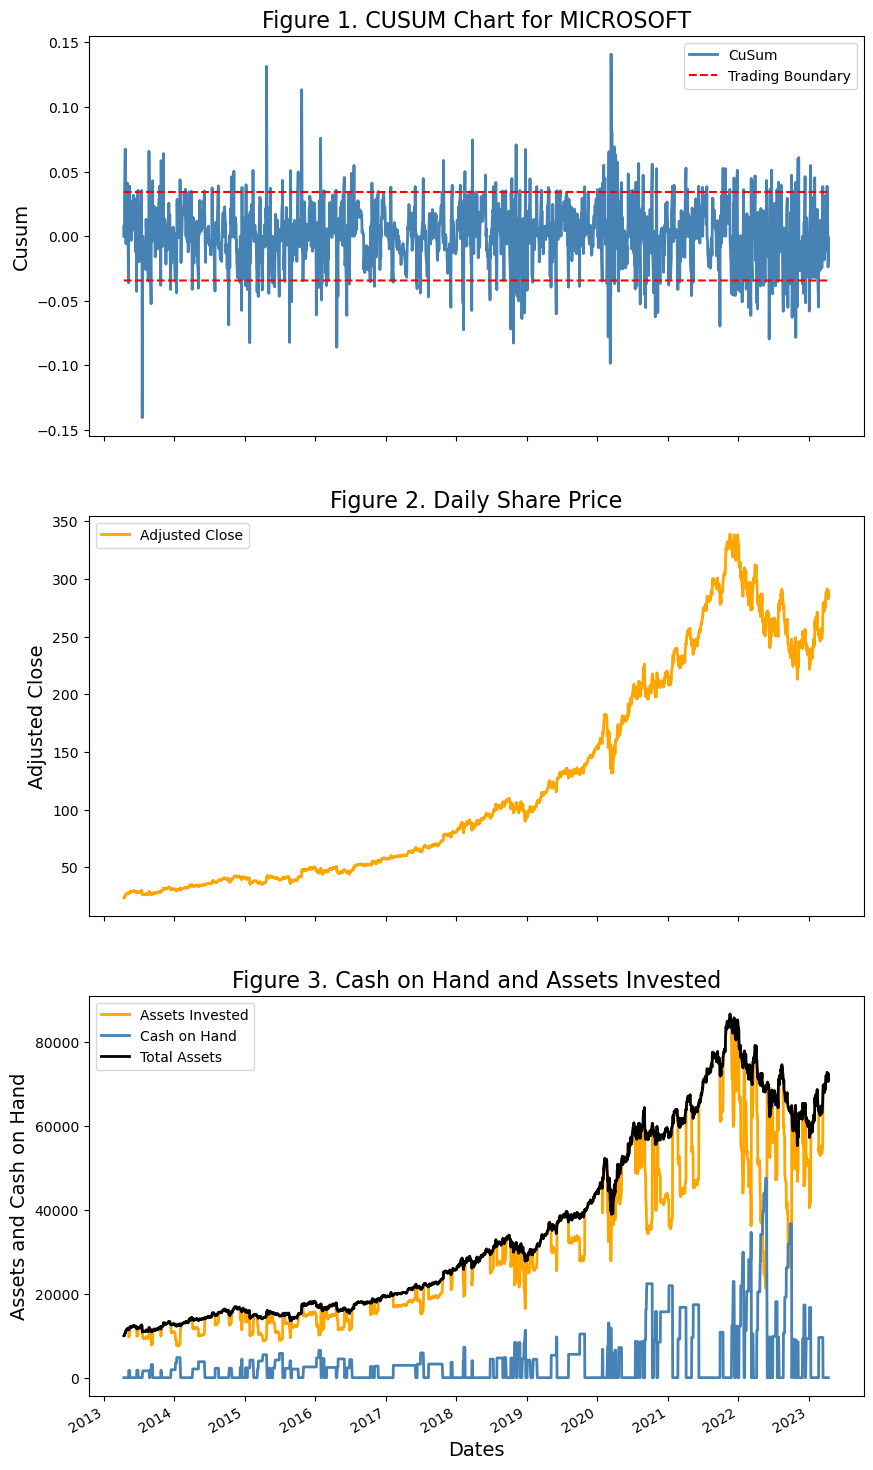

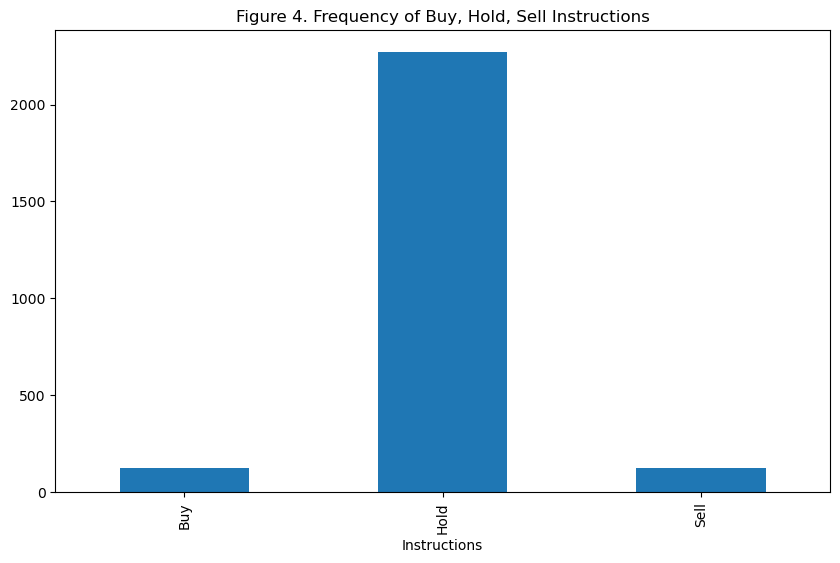

In [40]:
# Step 3 Calculate the mean growth rate and convert growth rate data to a list for manipulation.
# For the sake of this exercise, let k = the mean growth rate.
k2 = MSFT_growth['Adj Close'].mean()
# For the sake of this exercise, we will consider various thresholds for h. There are more sophisicated methods for setting h,
# but the article upon which this is based proposes simple thresholds, including 10k, 20k, 30k, et cetera.
h1 = 10*k2
h2 = 20*k2
h3 = 30*k2
h4 = 60*k2
# We will for ease of calculation, convert our dataframe column to a list.
Adj_Close2 = MSFT_growth['Adj Close'].tolist()

# Step 4 
# Initialize your cumulative sum
S = [0]
# Initialize your Instructions
I = ['Hold']
# Initialize assets invested
AINV = [10000]
# Initialize cash on hand.
CHELD = [0]
# Parameter on the share of cash on hand to use in case to buy if thresholds are reached.
bshare = 1
# Parameter on the share of assets to sell if thresholds are reached.
sshare = 0.15
# Set threshold
thresh = h3
# We will perform these calculations interatively.
for t in range(1, len(Adj_Close)):
    if len(S) == 1: #For the first run though, we simply calculate the value. This avoids an out of index problem.
        Snew = S[t-1] + (Adj_Close2[t] - k2) #This is the sum accumulator.
        S.append(Snew) # Populate the S list.
        I.append('Hold') # Populate Instruction List
        Avalue = AINV[t-1]*(1+Adj_Close2[t]) #Increase the value of existing assets by the amount of the growth in the stock.
        AINV.append(Avalue) #Populate the assets invested file.
        CHchanged = CHELD[t-1]
        CHELD.append(CHchanged)
    else:
        if S[t-1] >= thresh: # Instructions if the upper threshold is passed. (Buy)
            Snew = 0 # Revert value back to zero
            S.append(Snew) 
            I.append('Buy')
            Avalue = AINV[t-1]*(1+Adj_Close2[t]) + bshare*CHELD[t-1] #Increase the value of existing assets by the amount of the growth in the stock. Add any additional purchases.
            CHchanged = (1- bshare)*CHELD[t-1] #Adjust the cash on hand
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        elif S[t-1] <= -thresh: # Instructions if the lower threshold is passed. (Sell)
            Snew = 0
            S.append(Snew)
            I.append('Sell')
            Avalue = AINV[t-1]*(1+Adj_Close2[t]) - sshare*AINV[t-1]
            CHchanged = CHELD[t-1] + sshare*AINV[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
        else:
            Snew = S[t-1] + (Adj_Close2[t] - k2) # Instructions to hold are passed because the result is within boundaries.
            S.append(Snew)
            I.append('Hold')
            Avalue = AINV[t-1]*(1+Adj_Close2[t])
            CHchanged = CHELD[t-1]
            AINV.append(Avalue)
            CHELD.append(CHchanged)
            
# Initialize assets invested
AINV2_2 = [10000]
for k in range(1, len(Adj_Close)):
       Avalue2_2 = AINV2_2[k-1]*(1+Adj_Close2[k]) #Increase the value of existing assets by the amount of the growth in the stock.
       AINV2_2.append(Avalue2_2) #Populate the assets invested file.
    
# These steps are just adding columns to the data set.
MSFT_growth['S'] = S
MSFT_growth['Upper'] = h3
MSFT_growth['Lower'] = -h3
MSFT_growth['Instructions'] = I
MSFT_growth['Assets Invested'] = AINV
MSFT_growth['Cash on Hand'] = CHELD
MSFT_growth['Total Assets'] = MSFT_growth['Assets Invested'] + MSFT_growth['Cash on Hand']
MSFT_growth['Alt Assets'] = AINV2_2 
MSFT_growth

# Make a copy of the data frame.
MSFTdf_year = MSFT_growth.copy(deep = True)
# Reset the index on the copy to get the actual dates as a column.
MSFTdf_year.reset_index(inplace=True)
# Create a number column for just year
MSFTdf_year['year'] = pd.DatetimeIndex(MSFTdf_year['Date']).year
# Find the unique values in a column
years = MSFTdf_year.year.unique()
# Count total years from length of array
n_years = len(years) - 1
# Calculate the approximate annual growth rate of total assets
approx_growth = (MSFT_growth['Total Assets'][len(MSFT_growth['Total Assets']) - 1]/MSFT_growth['Total Assets'][0])**(1/n_years) - 1
approx_growth_alt = (MSFT_growth['Alt Assets'][len(MSFT_growth['Alt Assets']) - 1]/MSFT_growth['Alt Assets'][0])**(1/n_years) - 1
print("Assuming no commissions, the annualized rate of growth using a filter strategy with a threshold trading growth or decline of {:.2%} is {:.2%}".format(thresh, approx_growth))
print("The annualized rate of growth using a hold strategy is {:.2%}".format(approx_growth_alt))

import matplotlib.pyplot as plt 
#Truncate data sets for graphs
MSFT_growth_t = MSFT_growth['2013-04-15':'2023-04-13']
MSFTdf_t = MSFTdf['2013-04-15':'2023-04-13']
#Configure subplots
fig, axs = plt.subplots(3, sharex = True, figsize=(10,20))
#Specifying cusum plot
axs[0].plot(MSFT_growth_t['S'], label='CuSum', color='steelblue', linewidth = 2)
axs[0].plot(MSFT_growth_t['Upper'], label='Trading Boundary', color='red', linestyle='dashed')
axs[0].plot(MSFT_growth_t['Lower'], color='red', linestyle='dashed')
#Specifying share price plot
axs[1].plot(MSFTdf_t['Adj Close'], label="Adjusted Close", color='orange', linewidth=2)
#Specifying share price plot
axs[2].plot(MSFT_growth_t['Assets Invested'], label="Assets Invested", color='orange', linewidth=2)
axs[2].plot(MSFT_growth_t['Cash on Hand'], label="Cash on Hand", color='steelblue', linewidth=2)
axs[2].plot(MSFT_growth_t['Total Assets'], label="Total Assets", color='black', linewidth=2)
#add legends for both figures.
axs[0].legend()
axs[1].legend()
axs[2].legend()

#add axis labels and titles
axs[0].set_ylabel('Cusum', fontsize=14)
axs[1].set_ylabel('Adjusted Close', fontsize=14)
axs[2].set_ylabel('Assets and Cash on Hand', fontsize=14)
plt.xlabel('Dates', fontsize=14)
axs[0].set_title('Figure 1. CUSUM Chart for MICROSOFT', fontsize = 16)
axs[1].set_title('Figure 2. Daily Share Price', fontsize = 16)
axs[2].set_title('Figure 3. Cash on Hand and Assets Invested', fontsize = 16)
plt.gcf().autofmt_xdate()
#display plot
plt.show()
MSFT_growth['Instructions'].value_counts()

#Counting Frequencies of Buy, Hold, Sell Instructions
count = MSFT_growth_t.groupby(['Instructions']).count()
#Convert one column to a dataframe
countdf = pd.DataFrame(data=count['S'])
countdf.plot.bar(figsize = (10,6), title="Figure 4. Frequency of Buy, Hold, Sell Instructions", legend=False)
plt.show()

## CUSUM Method for Buying and Selling Decisions


The goal of this project was to use the CUSUM method to make buying and selling decisions for three stocks: Tesla, Meta, and Microsoft. We used three different thresholds for each stock to evaluate the performance of the CUSUM method and compare it to a simple buy and hold strategy.

## CUSUM Method Overview


The CUSUM method is a statistical technique used to detect changes in the mean value of a variable over time.

In this project, we applied the CUSUM method to stock prices to identify potential buying and selling opportunities. The CUSUM chart plots the cumulative sum of the deviations of the stock price from the mean over time. If the cumulative sum exceeds a certain threshold, we interpret this as a signal to buy the stock. Conversely, if the cumulative sum falls below a certain threshold, we interpret this as a signal to sell the stock. Although you normally want to buy low, sell high, this method uses the momentum of thee stock to make decisions. Momentum trading strategy is a type of trading strategy in which an investor buys stocks that are showing upward momentum or sell short stocks that are showing downward momentum.

## Data and Methodology


## Growth Rate with Thresholds using Filter and Hold Strategy


We analyzed the annualized rate of growth for Tesla, Meta, and Microsoft with three different thresholds using a filter strategy and a hold strategy. The filter strategy is based on a threshold trading growth or decline, while the hold strategy involves buying and holding the stock for the entire period.

The table below summarizes the results of our analysis for each threshold:

| Tesla Threshold              | Filter Strategy Threshold | Annualized Rate of Growth | Hold Strategy Annualized Rate of Growth |
|-----------------------------|---------------------------|----------------------------|-----------------------------------------|
| h1 (10x mean growth rate)    | 2.31%                     | 46.78%                     | 51.67%                                  |
| h2 (20x mean growth rate)    | 4.62%                     | 46.71%                     | 51.67%                                  |
| h3 (30x mean growth rate)    | 6.93%                     | 48.37%                     | 51.67%                                  |



| Meta Threshold              | Filter Strategy Threshold | Annualized Rate of Growth | Hold Strategy Annualized Rate of Growth |
|-----------------------------|---------------------------|----------------------------|-----------------------------------------|
| h1 (10x mean growth rate)    | 1.14%                     | 21.53%                     | 23.58%                                  |
| h2 (20x mean growth rate)    | 2.28%                     | 18.43%                     | 23.58%                                  |
| h3 (30x mean growth rate)    | 3.42%                     | 21.45%                     | 23.58%                                  |


| Microsoft Threshold              | Filter Strategy Threshold | Annualized Rate of Growth | Hold Strategy Annualized Rate of Growth |
|-----------------------------|---------------------------|----------------------------|-----------------------------------------|
| h1 (10x mean growth rate)    | 1.14%                     | 21.53%                     | 28.40%                                 |
| h2 (20x mean growth rate)    | 2.28%                     | 22.17%                     | 28.40%                                  |
| h3 (30x mean growth rate)    | 3.42%                     | 21.87%                     | 28.40%                                 |


Looking at the three tables, we can see that for Tesla, the annualized rate of growth under the filter strategy is lower than the hold strategy for all three thresholds. This indicates that the filter strategy did not perform as well as simply holding the stock for the entire period. However, the difference in growth rates between the two strategies is relatively small.

For Meta, the filter strategy had a lower annualized rate of growth than the hold strategy for the first and second thresholds, but a higher rate of growth for the third threshold. The differences between the two strategies are small in all cases.

For Microsoft, the filter strategy had a lower annualized rate of growth than the hold strategy for the first and third thresholds, but a higher rate of growth for the second threshold. Again, the differences between the two strategies are relatively small.



## Conclusion

The comparison of the annualized rate of growth for the filter strategy and the hold strategy across the three companies - Tesla, Microsoft, and Meta - suggests that the CUSUM strategy did not consistently outperform the hold strategy. In fact, the hold strategy often showed better annualized growth rates than the CUSUM strategy, especially at higher threshold levels.

This observation indicates that the CUSUM strategy did not prove to be an effective method for maximizing profits in these scenarios. While the CUSUM strategy was designed to trigger buy and sell signals based on deviations from a mean growth rate, the hold strategy simply involved buying and holding the stock for the entire period, without any active management.

There are several possible reasons why the hold strategy might have been more effective than the CUSUM strategy in these cases. For example, it is possible that the market conditions during the period favored a buy-and-hold approach, or that the deviations from the mean growth rate were not significant enough to justify the frequent buying and selling required by the CUSUM strategy. Additionally, it is possible that the CUSUM strategy could have performed better with different threshold levels or with different stocks altogether.